In [43]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import itertools
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from src.api.models.pydantic import SimRoomClassDTO
from src.config import TOBII_GLASSES_FPS, VIEWED_RADIUS
from ultralytics import YOLO
import subprocess

from experiment.settings import (
    CLASS_ID_TO_NAME,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    RECORDINGS_PATH,
    RECORDING_FRAMES_PATH,
    OBJECT_DETECTION_MODELS_PATH,
    COMPARISON_SETS_PATH,
    NAME_TO_CLASS_ID,
    OBJECT_DETECTION_PREDICTIONS_PATH,
    FINAL_PREDICTION_VIDEOS_PATH,
    IGNORED_CLASS_IDS,
    UNKNOWN_CLASS_ID,
    SIMROOM_ID,
    MISSING_GROUND_TRUTH_CLASS_ID,
    MISSING_PREDICTION_CLASS_ID
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service, gaze_service
import cv2
import numpy as np
import tempfile
from src.utils import extract_frames_to_dir
import albumentations as A
from tqdm import tqdm
import json
from torchvision.ops import box_iou
import torch
import collections
from src.api.utils import image_utils
from experiment import experiment_utils
from experiment.experiment_utils import CMMetrics
import multiprocessing
import functools
import itertools

IMG_CROP_SIZE = 640
IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

models = list(OBJECT_DETECTION_MODELS_PATH.glob("*.pt"))

# Object Detection Inference

## Inference - Create Comparison Sets

In [6]:
def get_frame_to_gaze_segmentation_data(
    gaze_segmentation_results_path: Path,
):
    if not gaze_segmentation_results_path.exists():
        raise ValueError(
            f"Gaze segmentation results path {gaze_segmentation_results_path} does not exist. Please run the gaze segmentation pipeline first."
        )

    frame_to_gaze_segmentation_data = {}
    for result in gaze_segmentation_results_path.glob("*.npz"):
        file = np.load(result)
        frame_idx = file["frame_idx"]
        frame_to_gaze_segmentation_data[int(frame_idx)] = {
            "boxes": file["boxes"],
            "object_ids": file["object_ids"].tolist(),
        }

    return frame_to_gaze_segmentation_data

def create_frame_crop(
    image: np.ndarray,
    gaze_position: tuple[int, int],
    frame_to_gaze_segmentation_data: dict[int, dict],
    frame_idx: int
) -> tuple[np.ndarray, list[tuple[int, int, int, int]], list[int]]:
    gaze_segmentation_boxes = frame_to_gaze_segmentation_data[frame_idx]["boxes"]
    gaze_segmentation_object_ids = frame_to_gaze_segmentation_data[frame_idx][
        "object_ids"
    ]

    # Create a crop around the gaze position
    cx, cy = gaze_position
    x_min = max(0, cx - IMG_CROP_SIZE_HALF)
    y_min = max(0, cy - IMG_CROP_SIZE_HALF)
    x_max = min(image.shape[1], cx + IMG_CROP_SIZE_HALF)
    y_max = min(image.shape[0], cy + IMG_CROP_SIZE_HALF)

    transform = A.Compose(
        [
            A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
            A.PadIfNeeded(min_height=IMG_CROP_SIZE, min_width=IMG_CROP_SIZE),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["object_ids"], min_visibility=0.7
        ),
    )

    transformed = transform(
        image=image,
        bboxes=gaze_segmentation_boxes,
        object_ids=gaze_segmentation_object_ids,
    )
    transformed_image = transformed["image"]
    transformed_gs_boxes = transformed["bboxes"]
    transformed_gs_object_ids = transformed["object_ids"]

    return transformed_image, transformed_gs_boxes, transformed_gs_object_ids

def get_comparison_dataset(
    recording_id: str,
    model: YOLO,
    frame_paths: list[Path],
    frame_to_gaze_position: dict[int, tuple[int, int]],
    frame_to_gaze_segmentation_data: dict[int, dict],
) -> None:
    comparison_set_per_frame = {}
    
    for frame_path in tqdm(frame_paths, desc=f"Running inference for {recording_id}"):
        frame_idx = int(frame_path.stem)
        if frame_to_gaze_segmentation_data.get(frame_idx) is None:
            continue

        image = cv2.imread(str(frame_path))
        gaze_position = frame_to_gaze_position[frame_idx]

        transformed_image, transformed_gs_boxes, transformed_gs_object_ids = create_frame_crop(
            image,
            gaze_position,
            frame_to_gaze_segmentation_data,
            frame_idx
        )

        results = model.predict(
            source=transformed_image, conf=0.5, iou=0.5, device="cuda", verbose=False
        )

        predicted_confidences = []
        predicted_bboxes = []
        predicted_class_ids = []
        for box in results[0].boxes:
            conf = float(box.conf[0].cpu().numpy())
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            predicted_confidences.append(conf)
            predicted_bboxes.append((int(x1), int(y1), int(x2), int(y2)))
            predicted_class_ids.append(class_id)

        comparison_set_per_frame[frame_idx] = {
            "gaze_segmentation": {
                "boxes": transformed_gs_boxes.astype(np.int32).tolist(),
                "object_ids": transformed_gs_object_ids,
            },
            "predicted": {
                "boxes": predicted_bboxes,
                "class_ids": predicted_class_ids,
                "confidences": predicted_confidences,
            },
        }

    return comparison_set_per_frame

In [7]:
for model in models:
    model_name = model.stem
    model_comparison_sets_path = COMPARISON_SETS_PATH / model_name

    if model_comparison_sets_path.exists():
        shutil.rmtree(model_comparison_sets_path)
    model_comparison_sets_path.mkdir(parents=True, exist_ok=True)

    print(
        f"Running inference for model {model_name} on {len(FULLY_LABELED_RECORDINGS)} fully labeled recordings"
    )
    for recording_id in FULLY_LABELED_RECORDINGS:
        comparison_set_path = model_comparison_sets_path / f"{recording_id}.json"

        # Get gaze segmentation data for the recording
        gaze_segmentation_results_path = GAZE_SEGMENTATION_RESULTS_PATH / recording_id
        frame_to_gaze_segmentation_data = get_frame_to_gaze_segmentation_data(
            gaze_segmentation_results_path
        )

        # Get frames for the recording
        recording_frames_path = RECORDING_FRAMES_PATH / recording_id
        frames = list(recording_frames_path.glob("*.jpg"))

        # Get gaze positions for the recording
        frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(
            recording_id, len(frames)
        )

        comparison_set_per_frame = get_comparison_dataset(
            recording_id=recording_id, 
            model=YOLO(model), 
            frame_paths=frames,
            frame_to_gaze_position=frame_to_gaze_position,
            frame_to_gaze_segmentation_data=frame_to_gaze_segmentation_data
        )

        with open(comparison_set_path, "w") as f:
            f.write(json.dumps(comparison_set_per_frame, indent=4))

Running inference for model same_background_640_3000 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:22<00:00, 92.59it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:16<00:00, 81.78it/s] 


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:16<00:00, 94.96it/s] 


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:16<00:00, 89.59it/s] 
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:14<00:00, 84.70it/s] 
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:19<00:00, 79.99it/s]
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:16<00:00, 76.75it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:30<00:00, 66.96it/s]


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:22<00:00, 69.48it/s]
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:20<00:00, 67.51it/s]


Running inference for model same_background_640_500 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:23<00:00, 86.92it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:17<00:00, 77.26it/s]


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:16<00:00, 92.16it/s] 


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:17<00:00, 85.94it/s]
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:15<00:00, 81.23it/s]
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:20<00:00, 77.02it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:16<00:00, 75.75it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:29<00:00, 68.98it/s]


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:22<00:00, 69.16it/s]
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:20<00:00, 65.99it/s]


Running inference for model same_background_640_1000 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:23<00:00, 86.92it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:18<00:00, 75.03it/s]


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:17<00:00, 90.67it/s] 


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:17<00:00, 83.50it/s]
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:14<00:00, 83.54it/s]
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:20<00:00, 75.03it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:17<00:00, 73.87it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:29<00:00, 69.86it/s]


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:21<00:00, 73.11it/s]
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:20<00:00, 67.49it/s]


Running inference for model same_background_640_2000 on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:24<00:00, 84.80it/s] 


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:18<00:00, 74.74it/s]


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:17<00:00, 88.76it/s] 


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:18<00:00, 81.50it/s]
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:15<00:00, 78.12it/s]
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:20<00:00, 74.42it/s]
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:17<00:00, 72.02it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:30<00:00, 66.59it/s]


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:22<00:00, 70.43it/s]
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:20<00:00, 65.66it/s]


### Validate Comparison Sets

In [ ]:
def uncrop_box(
    box,
    gaze_position: tuple[int, int],
    image_width: int,
    image_height: int,
) -> tuple[int, int, int, int]:
    IMG_CROP_SIZE = 640
    IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

    cx, cy = gaze_position
    x_min = max(0, cx - IMG_CROP_SIZE_HALF)
    y_min = max(0, cy - IMG_CROP_SIZE_HALF)

    x1, y1, x2, y2 = box
    x1 = int(x1 + x_min)
    y1 = int(y1 + y_min)
    x2 = int(x2 + x_min)
    y2 = int(y2 + y_min)

    return (x1, y1, x2, y2)


def create_comparison_set_validation_video(
    class_names: dict[int, str],
    comparison_set: dict,
    recording_id: str,
    video_result_path: Path,
):
    print("Extracting frames")
    frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
    tmp_frames_path = Path(tmp_frames_dir.name)

    frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(
        recording_id, frame_count=len(frames)
    )

    print("Drawing frames")
    for frame_path in tqdm(frames):
        frame_idx = int(frame_path.stem)

        if comparison_set.get(str(frame_idx)) is None:
            continue

        gx, gy = frame_to_gaze_position[frame_idx]

        frame_comparison_set = comparison_set[str(frame_idx)]
        image = cv2.imread(str(frame_path))

        gs_boxes = frame_comparison_set["gaze_segmentation"]["boxes"]
        gs_object_ids = frame_comparison_set["gaze_segmentation"]["object_ids"]

        predicted_boxes = frame_comparison_set["predicted"]["boxes"]
        predicted_class_ids = frame_comparison_set["predicted"]["class_ids"]
        predicted_confidences = frame_comparison_set["predicted"]["confidences"]

        gs_metadata = zip(gs_boxes, gs_object_ids)
        pred_metadata = zip(predicted_boxes, predicted_class_ids, predicted_confidences)

        for box, object_id in gs_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"GS: {object_id}",
                color="#FF0000",
            )

        for box, class_id, confidence in pred_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"{class_names[class_id]} {confidence:.2f}",
                color="#00FF00",
            )

        # Draw gaze position
        image = cv2.circle(image, (gx, gy), VIEWED_RADIUS, (0, 0, 255), -1)

        # Draw frame index in top left corner of the video
        cv2.putText(
            image,
            f"Frame: {frame_idx}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),
            2,
        )

        # in the bottom left, draw a list of all object ids that were detected in the frame
        object_ids = set(gs_object_ids + predicted_class_ids)
        object_ids_text = "Objects: " + ", ".join([
            f"{object_id}"
            for object_id in object_ids
            if object_id not in IGNORED_CLASS_IDS
        ])
        cv2.putText(
            image,
            object_ids_text,
            (10, image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        # in the bottom right, above the object ids, draw the class ids in this frame (NOT OBJECT IDS)
        class_ids_text = "Class IDs: " + ", ".join([
            f"{class_id}"
            for class_id in set(predicted_class_ids)
            if class_id not in IGNORED_CLASS_IDS
        ])
        cv2.putText(
            image,
            class_ids_text,
            (image.shape[1] - 200, image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        # save image
        cv2.imwrite(frame_path, image)

    print(f"Creating video for {recording_id}")
    cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
    subprocess.run(cmd, shell=True)


COMPARISON_SET_VALIDATION_VIDEOS_PATH = Path("data/comparison_set_validation_videos")
if COMPARISON_SET_VALIDATION_VIDEOS_PATH.exists():
    shutil.rmtree(COMPARISON_SET_VALIDATION_VIDEOS_PATH)
COMPARISON_SET_VALIDATION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

for model in models:
    model_name = model.stem
    yolo_model = YOLO(model)
    names = yolo_model.names

    video_results_path = COMPARISON_SET_VALIDATION_VIDEOS_PATH / model_name
    if not video_results_path.exists():
        video_results_path.mkdir(parents=True, exist_ok=True)

    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:
        recording_id = comparison_set_path.stem
        if recording_id != "89b60530-e0e4-4f5d-9ee6-af85c8d99ff4":
            continue

        comparison_set = json.loads(comparison_set_path.read_text())

        create_comparison_set_validation_video(
            names,
            comparison_set=comparison_set,
            recording_id=comparison_set_path.stem,
            video_result_path=video_results_path / f"{comparison_set_path.stem}.mp4",
        )

Extracting frames
Drawing frames


  2%|▏         | 22/1270 [00:00<00:07, 163.84it/s]


KeyboardInterrupt: 

## Inference - Intersect Comparison Sets

In [8]:
def get_thresholded_predictions(
    pred_data: dict,
    min_pred_conf: float
):
    pred_boxes = pred_data["boxes"]
    pred_confs = pred_data["confidences"]
    pred_class_ids = pred_data["class_ids"]

    # Filter out low confidence predictions
    thresholded_predictions = [
        (box, conf, class_id)
        for box, conf, class_id in zip(pred_boxes, pred_confs, pred_class_ids)
        if conf >= min_pred_conf
    ]
    return thresholded_predictions

def remove_duplicate_predictions(
    thresholded_predictions: list[tuple],
):
    best_per_class = {}  # {class_id: (box, conf, class_id)}
    for box, conf, class_id in thresholded_predictions:
        if class_id not in best_per_class or conf > best_per_class[class_id][1]:
            best_per_class[class_id] = (box, conf, class_id)
    return list(best_per_class.values())
    
def get_matched_boxes_per_frame(
    comparison_set: dict,
    min_pred_conf: float,
    iou_threshold: float,
):
    matched_boxes_per_frame = {}

    for frame_idx, frame_data in comparison_set.items():
        pred_data = frame_data["predicted"]
        gs_boxes = frame_data["gaze_segmentation"]["boxes"]
        gs_object_ids = frame_data["gaze_segmentation"]["object_ids"]

        thresholded_predictions = get_thresholded_predictions(
            pred_data=pred_data,
            min_pred_conf=min_pred_conf,
        )
        if len(thresholded_predictions) == 0:
            # No predictions above the confidence threshold
            continue

        predictions = remove_duplicate_predictions(
            thresholded_predictions=thresholded_predictions,
        )
        pred_boxes, pred_confs, pred_class_ids = zip(*predictions)

        # For each GS box, find its best OD match above threshold
        potential_matches = []  # Stores (iou_score, gs_idx, pred_idx)
        for i, gs_box in enumerate(gs_boxes):
            best_iou_for_gs_box = -1.0
            best_pred_idx_for_gs_box = -1

            for j, pred_box in enumerate(pred_boxes):
                iou = float(box_iou(torch.tensor([gs_box]), torch.tensor([pred_box])))

                if iou > best_iou_for_gs_box:
                    best_iou_for_gs_box = iou
                    best_pred_idx_for_gs_box = j

            if best_iou_for_gs_box >= iou_threshold:  # Use >= to include threshold itself
                potential_matches.append((
                    best_iou_for_gs_box,
                    i,
                    best_pred_idx_for_gs_box,
                ))

        # Sort potential matches by IoU score in descending order
        potential_matches.sort(key=lambda x: x[0], reverse=True)

        # Initialize lists for the matched pairs for this frame
        matched_gs_info = {"boxes": [], "object_ids": []}
        matched_pred_info = {"boxes": [], "class_ids": [], "confidences": []}
        matched_ious = []

        used_gs_indices = set()
        used_pred_indices = set()

        # Greedy selection of one-to-one matches
        for iou, gs_idx, pred_idx in potential_matches:
            if gs_idx not in used_gs_indices and pred_idx not in used_pred_indices:
                # This is a valid one-to-one match
                matched_gs_info["boxes"].append(gs_boxes[gs_idx])
                matched_gs_info["object_ids"].append(gs_object_ids[gs_idx])

                matched_pred_info["boxes"].append(pred_boxes[pred_idx])
                matched_pred_info["class_ids"].append(pred_class_ids[pred_idx])
                matched_pred_info["confidences"].append(pred_confs[pred_idx])

                matched_ious.append(iou)

                used_gs_indices.add(gs_idx)
                used_pred_indices.add(pred_idx)

        # Store results for the frame, but only if there are matches
        if len(matched_gs_info["boxes"]) > 0:
            matched_boxes_per_frame[frame_idx] = {
                "gaze_segmentation_matched": matched_gs_info,
                "predicted_matched": matched_pred_info,
                "ious": matched_ious,
            }

    return matched_boxes_per_frame


def get_predictions_per_object_id(
    matched_boxes_per_frame: dict,
):
    predictions_per_object_id = {}
    for frame_data in matched_boxes_per_frame.values():
        gs_matched = frame_data["gaze_segmentation_matched"]
        pred_matched = frame_data["predicted_matched"]

        for i, object_id in enumerate(gs_matched["object_ids"]):
            if object_id not in predictions_per_object_id:
                predictions_per_object_id[object_id] = []

            class_id = pred_matched["class_ids"][i]
            conf = pred_matched["confidences"][i]

            predictions_per_object_id[object_id].append({
                "class_id": class_id,
                "confidence": conf,
            })

    return predictions_per_object_id


def filter_by_min_observed_frames(
    predictions_per_object_id: dict,
    min_observed_frames: int,
):
    filtered_predictions = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if len(preds_list) >= min_observed_frames:
            filtered_predictions[object_id] = preds_list
    return filtered_predictions


def get_final_prediction_per_object_id(
    predictions_per_object_id: dict,
):
    best_prediction_per_class = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if not preds_list:
            raise ValueError(
                f"Predictions list for object ID {object_id} is empty. This should not happen."
            )

        class_confidence_sums = collections.defaultdict(float)
        for pred_info in preds_list:
            class_id = pred_info["class_id"]
            confidence = pred_info["confidence"]
            class_confidence_sums[class_id] += confidence

        # Find the class_id with the highest summed confidence
        # .items() gives (key, value) pairs. We want to find the max by value.
        # If there's a tie, max() will return one of them (typically the first one
        # encountered that achieves the maximum value, or based on key order if values are equal).
        winning_class_id = max(class_confidence_sums, key=class_confidence_sums.get)
        max_summed_confidence = class_confidence_sums[winning_class_id]

        prev_best = best_prediction_per_class.get(winning_class_id, None)
        if prev_best is None or prev_best["confidence"] < max_summed_confidence:
            best_prediction_per_class[winning_class_id] = {
                "object_id": object_id,
                "confidence": max_summed_confidence,
            }

    predictions_per_object_id = {}
    for class_id, pred_info in best_prediction_per_class.items():
        object_id = pred_info["object_id"]
        predictions_per_object_id[object_id] = {
            "class_id": class_id,
            "confidence": pred_info["confidence"],
        }

    return predictions_per_object_id

def get_predictions_df(
    model_class_names: dict[int, str],
    comparison_set_path: Path,
    min_pred_conf: float,
    iou_threshold: float,
    min_observed_frames: int,
):
    comparison_set = json.loads(comparison_set_path.read_text())

    matched_boxes_per_frame = get_matched_boxes_per_frame(
        comparison_set=comparison_set,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
    )

    predictions_per_object_id = get_predictions_per_object_id(
        matched_boxes_per_frame=matched_boxes_per_frame
    )

    predictions_per_object_id = filter_by_min_observed_frames(
        predictions_per_object_id=predictions_per_object_id,
        min_observed_frames=min_observed_frames,
    )

    final_predictions_per_object_id = get_final_prediction_per_object_id(
        predictions_per_object_id=predictions_per_object_id
    )

    predictions_df = experiment_utils.get_object_df(
        recording_id=comparison_set_path.stem,
        drop_embedding=True,
    )

    for idx, row in predictions_df.iterrows():
        object_id = row["object_id"]

        if final_predictions_per_object_id.get(object_id) is None:
            predictions_df.at[idx, "predicted_class_id"] = UNKNOWN_CLASS_ID
            continue

        pred_result = final_predictions_per_object_id[int(object_id)]
        pred_class_id = pred_result["class_id"]
        pred_conf = pred_result["confidence"]
        class_label = model_class_names[pred_class_id]

        # TODO: fix this in the model
        if class_label == "scherm":
            class_label = "monitor"

        system_class_id = NAME_TO_CLASS_ID.get(class_label, None)

        if system_class_id is None:
            raise ValueError(
                f"Class label {class_label} not found in NAME_TO_CLASS_ID mapping."
            )

        predictions_df.at[idx, "predicted_class_id"] = system_class_id
        predictions_df.at[idx, "predicted_confidence"] = pred_conf

    predictions_df.rename(
        columns={"predicted_confidence": "gs_confidence"}, inplace=True
    )

    return predictions_df

In [9]:
from multiprocessing import Pool
from pathlib import Path
import pandas as pd
from tqdm import tqdm


def validate_confusion_matrix(
    cm_metrics: CMMetrics,
    ground_truth_df: pd.DataFrame,
):
    ground_truth_df = experiment_utils.get_ground_truth_df(IGNORED_CLASS_IDS)
    true_support_per_class = ground_truth_df["class_id"].value_counts()
    for metrics in cm_metrics.per_class_metrics:
        class_id = metrics.class_id
        support = metrics.support
        true_support = true_support_per_class[class_id]

        if support != true_support:
            raise ValueError(
                f"Support for class {class_id} does not match. "
                f"Expected: {true_support}, "
                f"Got: {support}. "
            )


def evaluate_grid_combination(
    model_name: str,
    model_class_names: dict[int, str],
    ground_truth_df: pd.DataFrame,
    min_pred_conf: float,
    iou_threshold: float,
    min_observed_frames: int,
):
    cm = experiment_utils.create_confusion_matrix(IGNORED_CLASS_IDS)
    full_evaluation_df = pd.DataFrame()

    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:
        recording_id = comparison_set_path.stem

        predictions_df = get_predictions_df(
            model_class_names=model_class_names,
            comparison_set_path=comparison_set_path,
            min_pred_conf=min_pred_conf,
            iou_threshold=iou_threshold,
            min_observed_frames=min_observed_frames,
        )

        gt_df_recording = ground_truth_df[ground_truth_df["recording_id"] == recording_id]

        eval_df = experiment_utils.evaluate_predictions(
            predictions_df=predictions_df,
            gt_df=gt_df_recording,
        )
        full_evaluation_df = pd.concat(
            [full_evaluation_df, eval_df.assign(recording_id=recording_id)],
            ignore_index=True,
        )

        experiment_utils.update_confusion_matrix(cm, eval_df)

    cm_metrics = experiment_utils.confusion_matrix_metrics(cm)
    validate_confusion_matrix(cm_metrics, ground_truth_df)

    return full_evaluation_df, cm, cm_metrics


def _process_grid_combination(args: tuple):
    (
        model_name,
        model_class_names,
        ground_truth_df,
        min_pred_conf,
        iou_threshold,
        min_observed_frames,
    ) = args

    full_evaluation_df, cm, cm_metrics = evaluate_grid_combination(
        model_name=model_name,
        model_class_names=model_class_names,
        ground_truth_df=ground_truth_df,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
        min_observed_frames=min_observed_frames,
    )

    return {
        "model_name": model_name,
        "min_pred_conf": min_pred_conf,
        "iou_threshold": iou_threshold,
        "min_observed_frames": min_observed_frames,
        "cm": cm,
        "cm_metrics": cm_metrics,
        "full_evaluation_df": full_evaluation_df,
    }


def evaluate_model(
    model_name: Path,
    model_class_names: dict[int, str],
    ground_truth_df: pd.DataFrame,
    grid_search_params: list[tuple[float, float]],
):
    tasks_args = []
    for conf, iou, min_observed_frames in grid_search_params:
        tasks_args.append((
            model_name,
            model_class_names,
            ground_truth_df,
            conf,
            iou,
            min_observed_frames,
        ))

    with Pool() as pool:
        # print the number of processes being used and other information
        model_grid_search_results = list(
            tqdm(
                pool.imap(_process_grid_combination, tasks_args),
                total=len(tasks_args),
                desc=f"Evaluating model {model_name} with {len(tasks_args)} grid search combinations using {pool._processes} processes.",
            )
        )

    return model_grid_search_results

In [10]:
ground_truth_df = experiment_utils.get_ground_truth_df(IGNORED_CLASS_IDS)

min_pred_confs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
iou_thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
min_observed_frames = [0, 1, 3, 5, 7]

grid_search_params = list(
    itertools.product(min_pred_confs, iou_thresholds, min_observed_frames)
)

grid_search_results = []
for i, model_path in enumerate(models):
    print(f"Evaluating model {i + 1}/{len(models)}: {model_path.stem}")

    model = YOLO(model_path)
    model_grid_search_results = evaluate_model(
        model_name=model_path.stem,
        model_class_names=model.names,
        ground_truth_df=ground_truth_df,
        grid_search_params=grid_search_params,
    )
    grid_search_results.extend(model_grid_search_results)

Evaluating model 1/4: same_background_640_3000


Evaluating model same_background_640_3000 with 315 grid search combinations using 16 processes.: 100%|██████████| 315/315 [07:36<00:00,  1.45s/it]

Evaluating model 2/4: same_background_640_500



Evaluating model same_background_640_500 with 315 grid search combinations using 16 processes.: 100%|██████████| 315/315 [07:53<00:00,  1.50s/it]


Evaluating model 3/4: same_background_640_1000


Evaluating model same_background_640_1000 with 315 grid search combinations using 16 processes.: 100%|██████████| 315/315 [07:53<00:00,  1.50s/it]


Evaluating model 4/4: same_background_640_2000


Evaluating model same_background_640_2000 with 315 grid search combinations using 16 processes.: 100%|██████████| 315/315 [07:45<00:00,  1.48s/it]


# Interpret Grid Search Results

In [11]:
def get_best_grid_search_result(
    grid_sesarch_results: list[dict],
    metric: str,
):
    best_result = None
    best_value = -1.0

    for result in grid_sesarch_results:
        cm_metrics = result["cm_metrics"]
        value = getattr(cm_metrics, metric)

        if value > best_value:
            best_value = value
            best_result = result

    return best_result


def render_grid_search_result(result: dict):
    cm_metrics: CMMetrics = result["cm_metrics"]
    model_name = result["model_name"]
    min_pred_conf = result["min_pred_conf"]
    iou_threshold = result["iou_threshold"]
    min_observed_frames = result["min_observed_frames"]

    print(f"Model: {model_name}")
    print(f"Min Pred Conf: {min_pred_conf}")
    print(f"IoU Threshold: {iou_threshold}")
    print(f"Min Glance Frame Count: {min_observed_frames}")
    print()

    experiment_utils.print_confusion_matrix_metrics(cm_metrics)

    # Plot confusion matrix
    experiment_utils.render_confusion_matrix(result["cm"], show_absolute_counts=False)

Model: same_background_640_1000
Min Pred Conf: 0.85
IoU Threshold: 0.2
Min Glance Frame Count: 3

Overall Accuracy: 0.6690
Micro Precision: 0.9424
Micro Recall: 0.6976
Micro F1: 0.8017

Per Class Metrics:
Class Name Precision  Recall     F1         Support   
naaldcontainer 0.9810     0.9413     0.9607     715       
spuit      0.9118     0.4717     0.6218     460       
keukenmes  0.9623     0.6130     0.7489     416       
infuus     0.7571     0.6839     0.7186     465       
stethoscoop 0.9364     0.7666     0.8430     557       
bol wol    0.9716     0.8529     0.9084     442       
snoep      0.9848     0.5417     0.6989     360       
nuchter    0.9643     0.8244     0.8889     393       
fotokader  0.9774     0.6684     0.7939     389       
iced tea   0.9560     0.7221     0.8227     331       
bril       0.9000     0.7087     0.7930     381       
monitor    0.9974     0.7470     0.8542     506       
rollator   0.9531     0.7564     0.8435     349       
ampulevloeistof 1.00

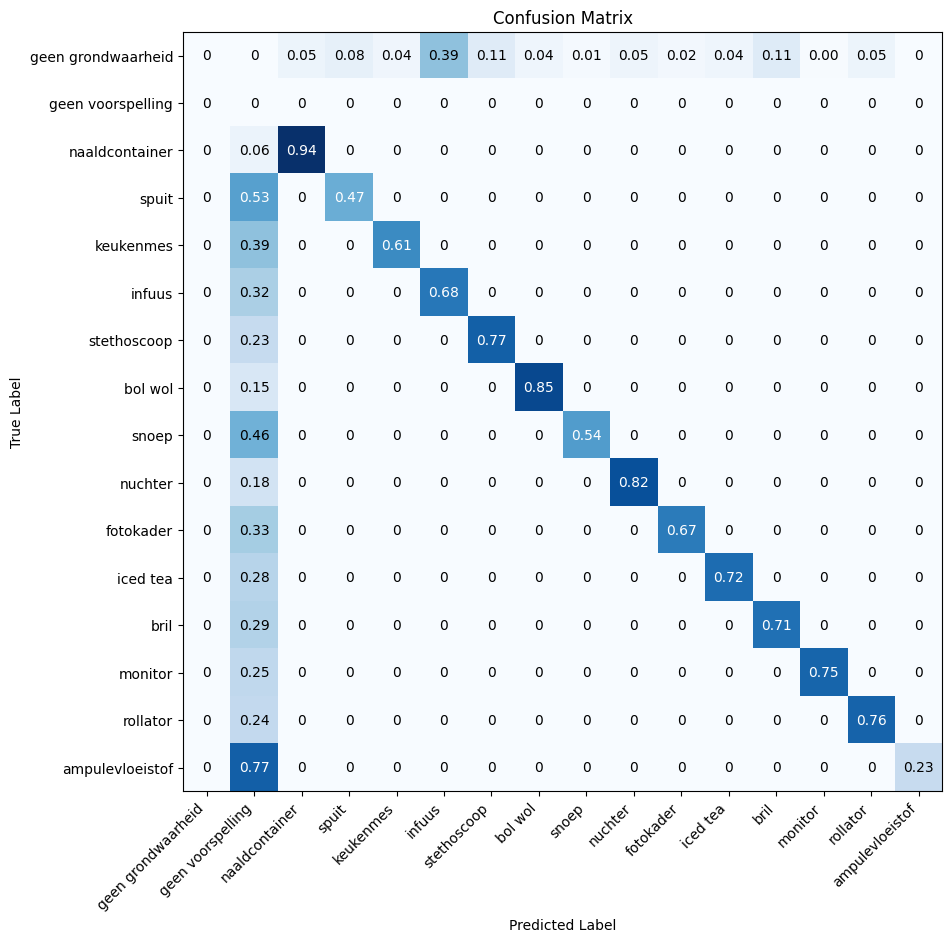

In [12]:
best_grid_search_result = get_best_grid_search_result(
    grid_sesarch_results=grid_search_results, metric="micro_f1"
)

render_grid_search_result(result=best_grid_search_result)

In [13]:
sample_counts = [
    int(model.stem.split("_")[-1]) for model in models
]
# sort by sample counts
models = sorted(models, key=lambda x: int(x.stem.split("_")[-1]))

for model in models:
    model_results = [result for result in grid_search_results if result["model_name"] == model.stem]
    
    best_result = get_best_grid_search_result(
        grid_sesarch_results=model_results, metric="micro_f1"
    )
    cm_metrics = best_result["cm_metrics"]

    print(f"Best result for model {model.stem}: ")
    print(f"Min Pred Conf: {best_result['min_pred_conf']} "
          f"IoU Threshold: {best_result['iou_threshold']} "
          f"Min Glance Frame Count: {best_result['min_observed_frames']}")
    print(f"F1: {cm_metrics.micro_f1}\n"
          f"Precision: {cm_metrics.micro_precision}\n"
          f"Recall: {cm_metrics.micro_recall}")
    print()

Best result for model same_background_640_500: 
Min Pred Conf: 0.85 IoU Threshold: 0.3 Min Glance Frame Count: 0
F1: 0.7997739687323414
Precision: 0.9481911567664135
Recall: 0.6915309446254072

Best result for model same_background_640_1000: 
Min Pred Conf: 0.85 IoU Threshold: 0.2 Min Glance Frame Count: 3
F1: 0.8016846045858681
Precision: 0.9423542354235424
Recall: 0.697557003257329

Best result for model same_background_640_2000: 
Min Pred Conf: 0.85 IoU Threshold: 0.2 Min Glance Frame Count: 5
F1: 0.7974040632054177
Precision: 0.9436776491540516
Recall: 0.6903908794788274

Best result for model same_background_640_3000: 
Min Pred Conf: 0.85 IoU Threshold: 0.3 Min Glance Frame Count: 3
F1: 0.7993952565435131
Precision: 0.9520594193112761
Recall: 0.6889250814332247



Beste resultaat voor model same_background_640_500:
  Min Pred Conf: 0.85
  IoU Threshold: 0.3
  Min Observed Frames: 0
  Micro F1: 0.7998
  Micro Precision: 0.9482
  Micro Recall: 0.6915

Beste resultaat voor model same_background_640_1000:
  Min Pred Conf: 0.85
  IoU Threshold: 0.2
  Min Observed Frames: 3
  Micro F1: 0.8017
  Micro Precision: 0.9424
  Micro Recall: 0.6976

Beste resultaat voor model same_background_640_2000:
  Min Pred Conf: 0.85
  IoU Threshold: 0.2
  Min Observed Frames: 5
  Micro F1: 0.7974
  Micro Precision: 0.9437
  Micro Recall: 0.6904

Beste resultaat voor model same_background_640_3000:
  Min Pred Conf: 0.85
  IoU Threshold: 0.3
  Min Observed Frames: 3
  Micro F1: 0.7994
  Micro Precision: 0.9521
  Micro Recall: 0.6889



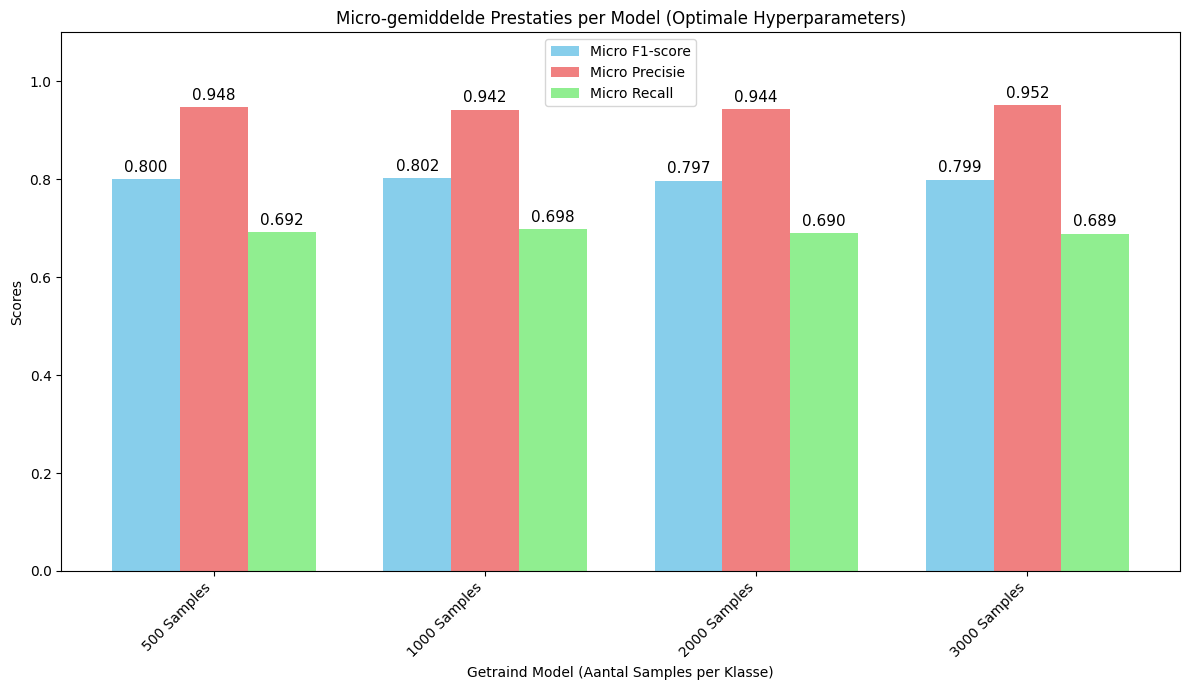

In [14]:
model_names_short = []
f1_scores = []
precision_scores = []
recall_scores = []

models = sorted(models, key=lambda x: int(x.stem.split("_")[-1]))

for model_path in models: # Gebruik 'model_path' om consistent te zijn met je eerdere code
    model_name_full = model_path.stem # bv. "same_background_640_500"
    
    # Extraheer het aantal samples voor de x-as label
    try:
        # Probeer het laatste deel te pakken, ervan uitgaande dat dit het aantal samples is
        num_samples = model_name_full.split("_")[-1]
        model_names_short.append(f"{num_samples} Samples")
    except IndexError:
        model_names_short.append(model_name_full) # Fallback naar volledige naam

    model_results_for_current_model = [
        result for result in grid_search_results if result["model_name"] == model_name_full
    ]
    
    if not model_results_for_current_model:
        print(f"Waarschuwing: Geen resultaten gevonden voor model {model_name_full}")
        f1_scores.append(0) # Voeg dummy waarden toe om de grafiek te kunnen maken
        precision_scores.append(0)
        recall_scores.append(0)
        continue

    best_result = get_best_grid_search_result(
        grid_sesarch_results=model_results_for_current_model, metric="micro_f1"
    )
    cm_metrics = best_result["cm_metrics"]

    f1_scores.append(cm_metrics.micro_f1)
    precision_scores.append(cm_metrics.micro_precision)
    recall_scores.append(cm_metrics.micro_recall)

    # Print de beste resultaten (optioneel, maar handig voor verificatie)
    print(f"Beste resultaat voor model {model_name_full}:")
    print(f"  Min Pred Conf: {best_result['min_pred_conf']}")
    print(f"  IoU Threshold: {best_result['iou_threshold']}")
    print(f"  Min Observed Frames: {best_result['min_observed_frames']}") # Hernoemd van 'glance'
    print(f"  Micro F1: {cm_metrics.micro_f1:.4f}")
    print(f"  Micro Precision: {cm_metrics.micro_precision:.4f}")
    print(f"  Micro Recall: {cm_metrics.micro_recall:.4f}\n")


# Maak de bar chart
x = np.arange(len(model_names_short))  # de label locaties
width = 0.25  # de breedte van de bars

fig, ax = plt.subplots(figsize=(12, 7)) # Maak figuur en assen, pas grootte aan
rects1 = ax.bar(x - width, f1_scores, width, label='Micro F1-score', color='skyblue')
rects2 = ax.bar(x, precision_scores, width, label='Micro Precisie', color='lightcoral')
rects3 = ax.bar(x + width, recall_scores, width, label='Micro Recall', color='lightgreen')

# Voeg wat tekst toe voor labels, titel en custom x-as tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xlabel('Getraind Model (Aantal Samples per Klasse)')
ax.set_title('Micro-gemiddelde Prestaties per Model (Optimale Hyperparameters)')
ax.set_xticks(x)
ax.set_xticklabels(model_names_short, rotation=45, ha="right") # Roteer labels voor leesbaarheid
ax.legend()

# Functie om labels boven de bars toe te voegen (optioneel)
def autolabel(rects):
    """Bevestig een tekstlabel boven elke bar in *rects*, met de hoogte ervan."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punten verticale offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_ylim(0, 1.1) # Zorg dat y-as tot net boven 1.0 gaat
fig.tight_layout() # Zorgt dat alles netjes past

plt.show()

# Per-class Results

In [15]:
def get_class_id_to_color(session):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id="d6fd0aed-b901-4863-bad8-7910dad693e0"
    ).id

    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    class_id_to_color = {}
    for cls_ in tracked_classes:
        class_id_to_color[cls_.id] = cls_.color

    return class_id_to_color

naaldcontainer 42 715
spuit 243 460
keukenmes 161 416
infuus 147 465
stethoscoop 130 557
bol wol 65 442
snoep 165 360
nuchter 69 393
fotokader 129 389
iced tea 92 331
bril 111 381
monitor 128 506
rollator 85 349
ampulevloeistof 290 376


/tmp/ipykernel_165077/896693459.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy
/tmp/ipykernel_165077/896693459.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy


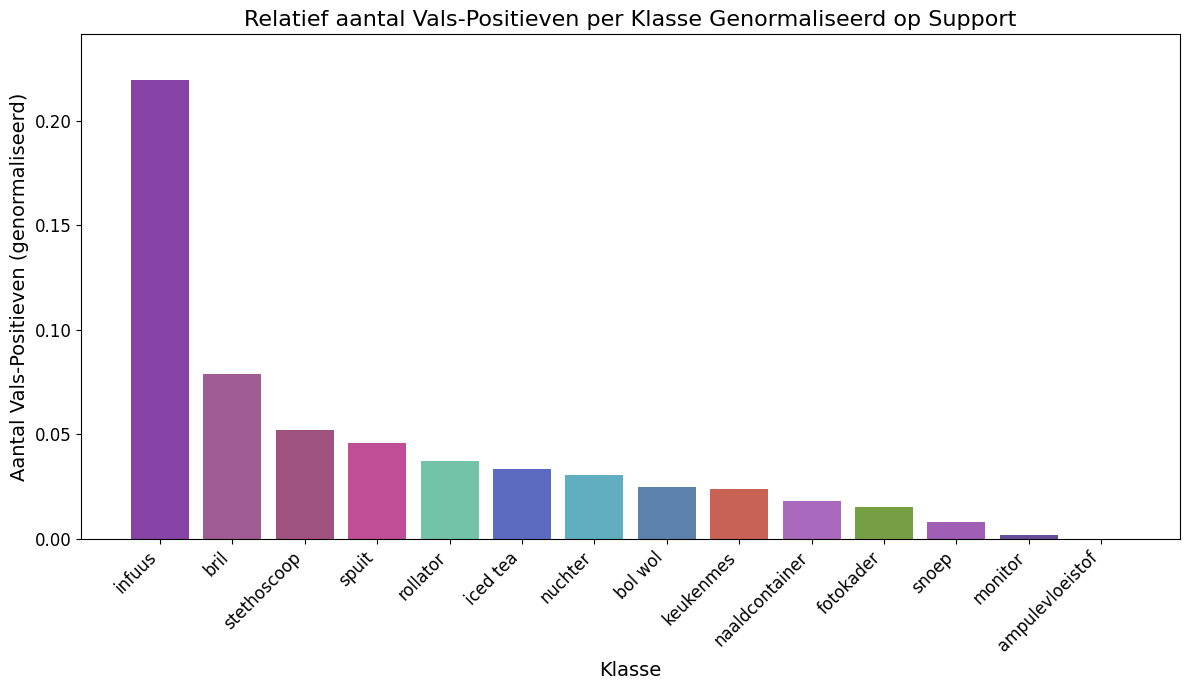

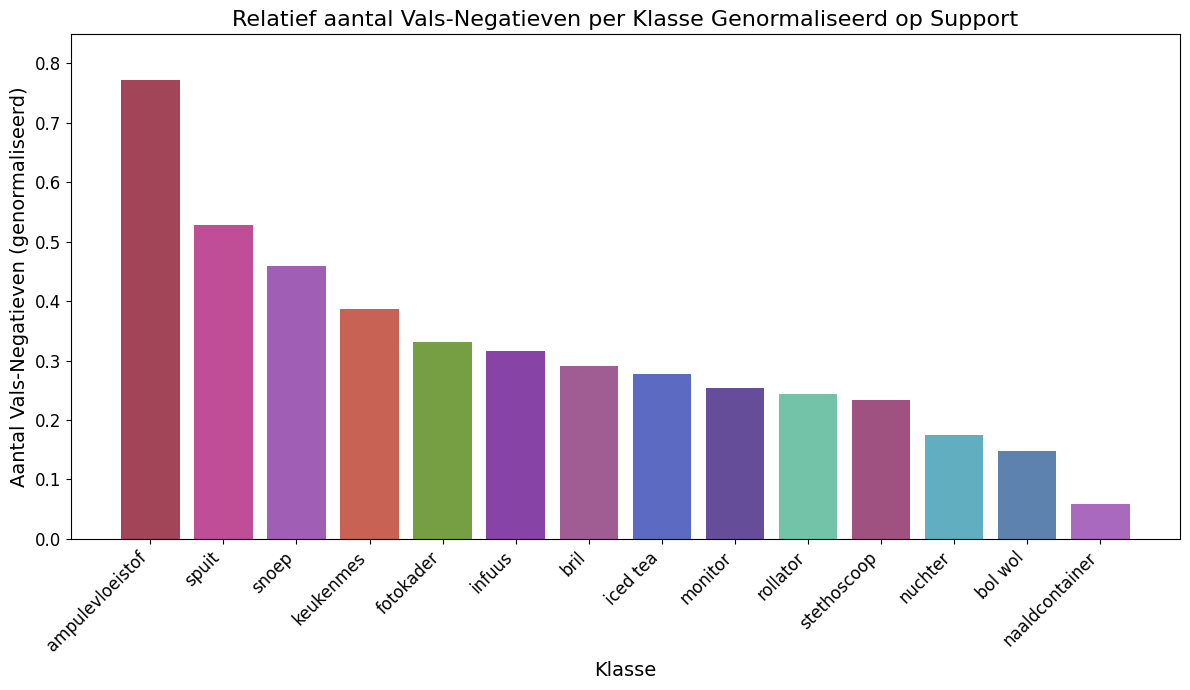

In [51]:
with Session(engine) as session:
    class_id_to_color = get_class_id_to_color(Session(bind=engine))


cm = best_grid_search_result["cm"]
cm_metrics: CMMetrics = best_grid_search_result["cm_metrics"]
per_class_metrics = cm_metrics.per_class_metrics

class_ids = []
recall_scores = []
fp_counts = []
fn_counts = []

for class_metrics in per_class_metrics:
    class_id = class_metrics.class_id
    class_ids.append(class_metrics.class_id)

    fp_count = cm.at[MISSING_GROUND_TRUTH_CLASS_ID, class_id]
    support = class_metrics.support
    normalized_fp_count = fp_count / support if support > 0 else 0
    fp_counts.append(normalized_fp_count)

    fn_count = cm.at[class_id, MISSING_PREDICTION_CLASS_ID]
    print(CLASS_ID_TO_NAME[class_id], fn_count, support)
    normalized_fn_count = fn_count / support if support > 0 else 0
    fn_counts.append(normalized_fn_count)


# Create a plot for false positives per class, sort by false positive count, give color based on class_id_to_color, x labels should be class names from CLASS_ID_TO_NAME
# DO NOT CREATE A PLOT FOR RECALL HERE
sorted_indices = np.argsort(fp_counts)[::-1] 
sorted_class_ids = [class_ids[i] for i in sorted_indices]
sorted_fp_counts = [fp_counts[i] for i in sorted_indices]
# Create a color list based on class_id_to_color
sorted_class_names = [CLASS_ID_TO_NAME[class_id] for class_id in sorted_class_ids]
colors = [class_id_to_color[class_id] for class_id in sorted_class_ids]

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(
    sorted_class_names,      # Use class names as x-values
    sorted_fp_counts,
    color=colors,
)
ax.set_xlabel("Klasse", fontsize=14)
ax.set_ylabel("Aantal Vals-Positieven (genormaliseerd)", fontsize=14)
ax.set_title("Relatief aantal Vals-Positieven per Klasse Genormaliseerd op Support", fontsize=16)
ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, max(sorted_fp_counts) * 1.1)
plt.tight_layout()

# Create a plot for the false-negatives per class in the same way
sorted_indices = np.argsort(fn_counts)[::-1] 
sorted_class_ids = [class_ids[i] for i in sorted_indices]
sorted_fn_counts = [fn_counts[i] for i in sorted_indices]
sorted_class_names = [CLASS_ID_TO_NAME[class_id] for class_id in sorted_class_ids]
colors = [class_id_to_color[class_id] for class_id in sorted_class_ids]

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(
    sorted_class_names,
    sorted_fn_counts,
    color=colors,
)
ax.set_xlabel("Klasse", fontsize=14)
ax.set_ylabel("Aantal Vals-Negatieven (genormaliseerd)", fontsize=14)
ax.set_title("Relatief aantal Vals-Negatieven per Klasse Genormaliseerd op Support", fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticklabels(sorted_class_names, rotation=45, ha="right", fontsize=12)  # Optional redundancy
ax.set_ylim(0, max(fn_counts) * 1.1)
plt.tight_layout()



# Further Analysis of Best Model

Number of false positives: 262
Predicted Class ID: 1.0 (naaldcontainer) with 13 false positives


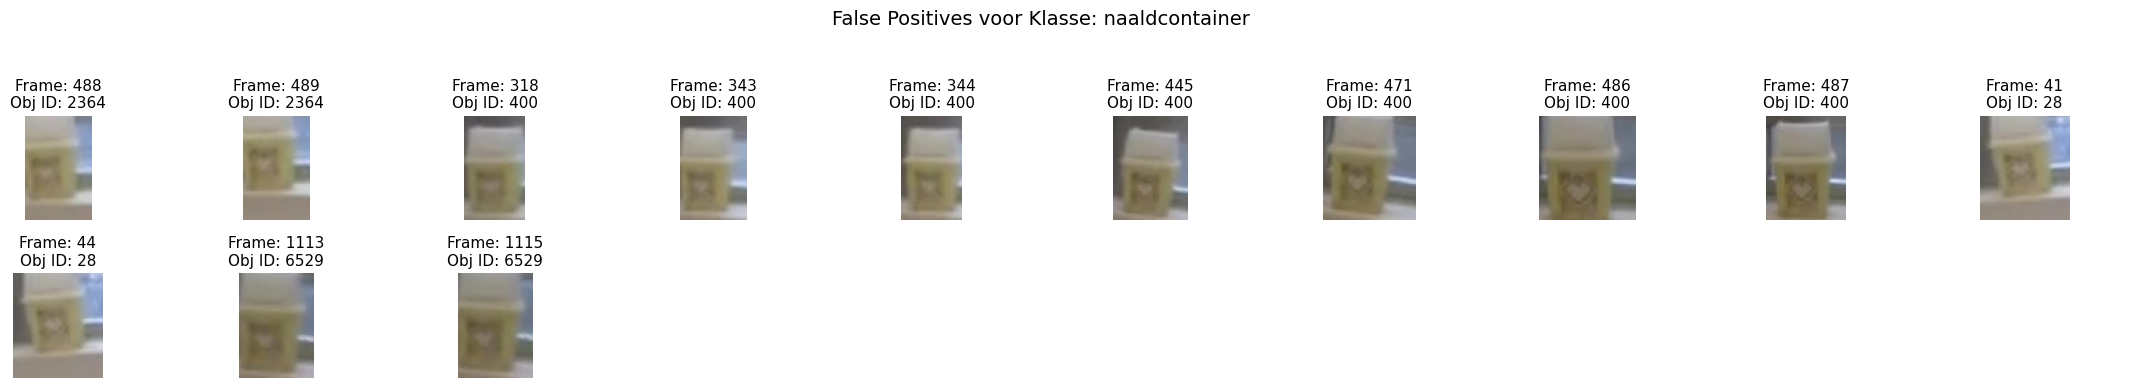

Predicted Class ID: 2.0 (spuit) with 21 false positives


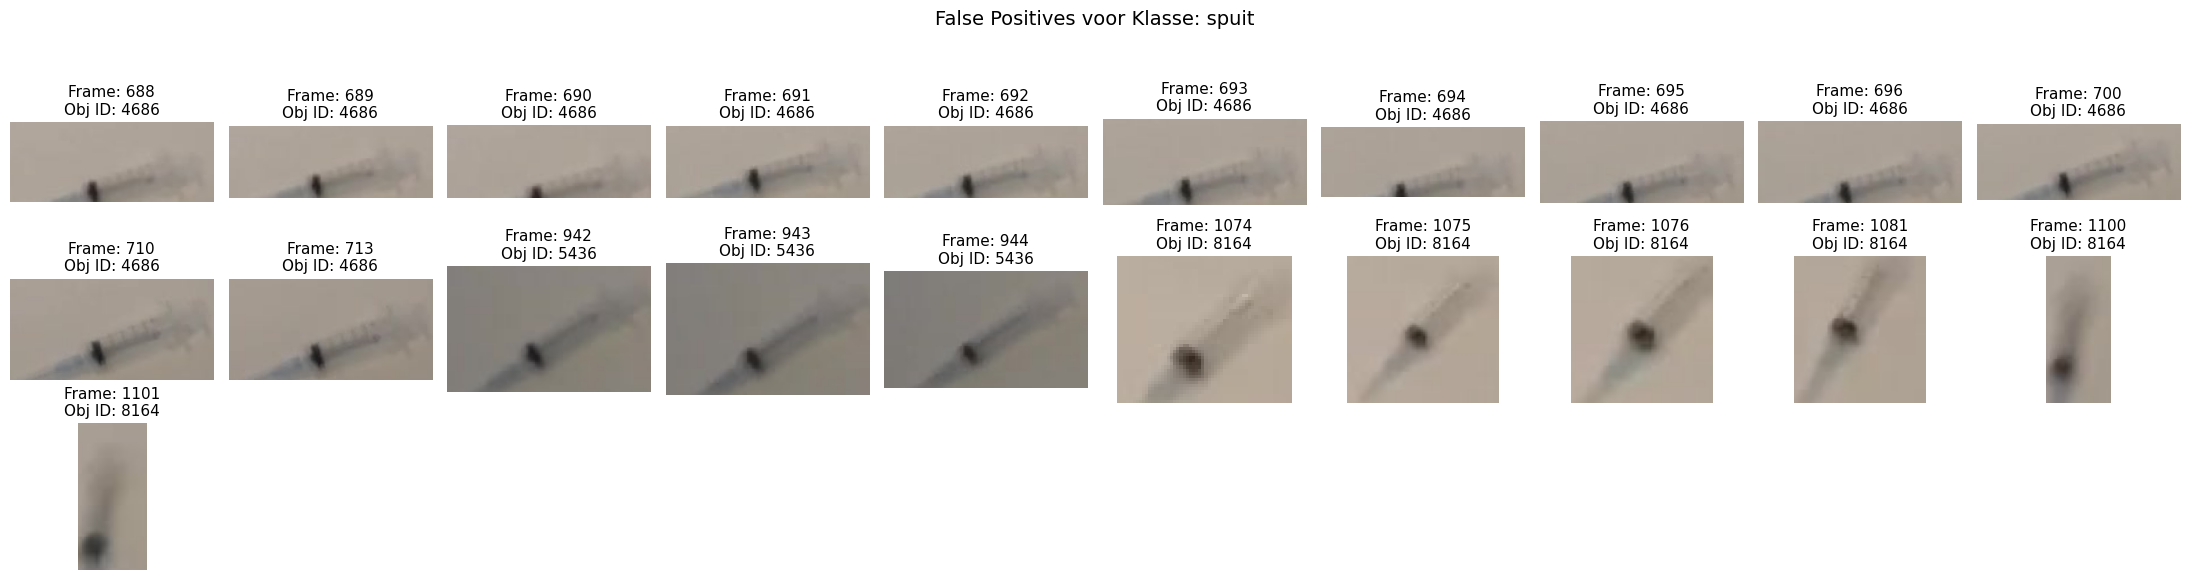

Predicted Class ID: 3.0 (keukenmes) with 10 false positives


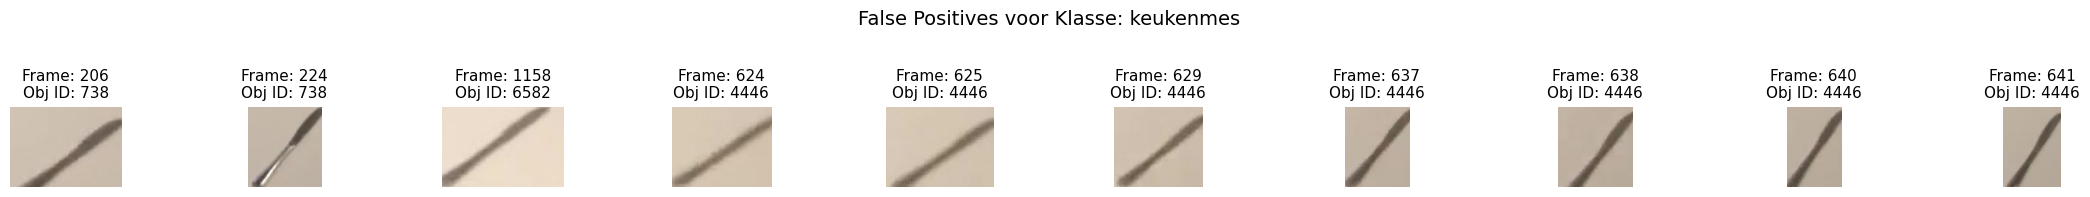

Predicted Class ID: 4.0 (infuus) with 102 false positives


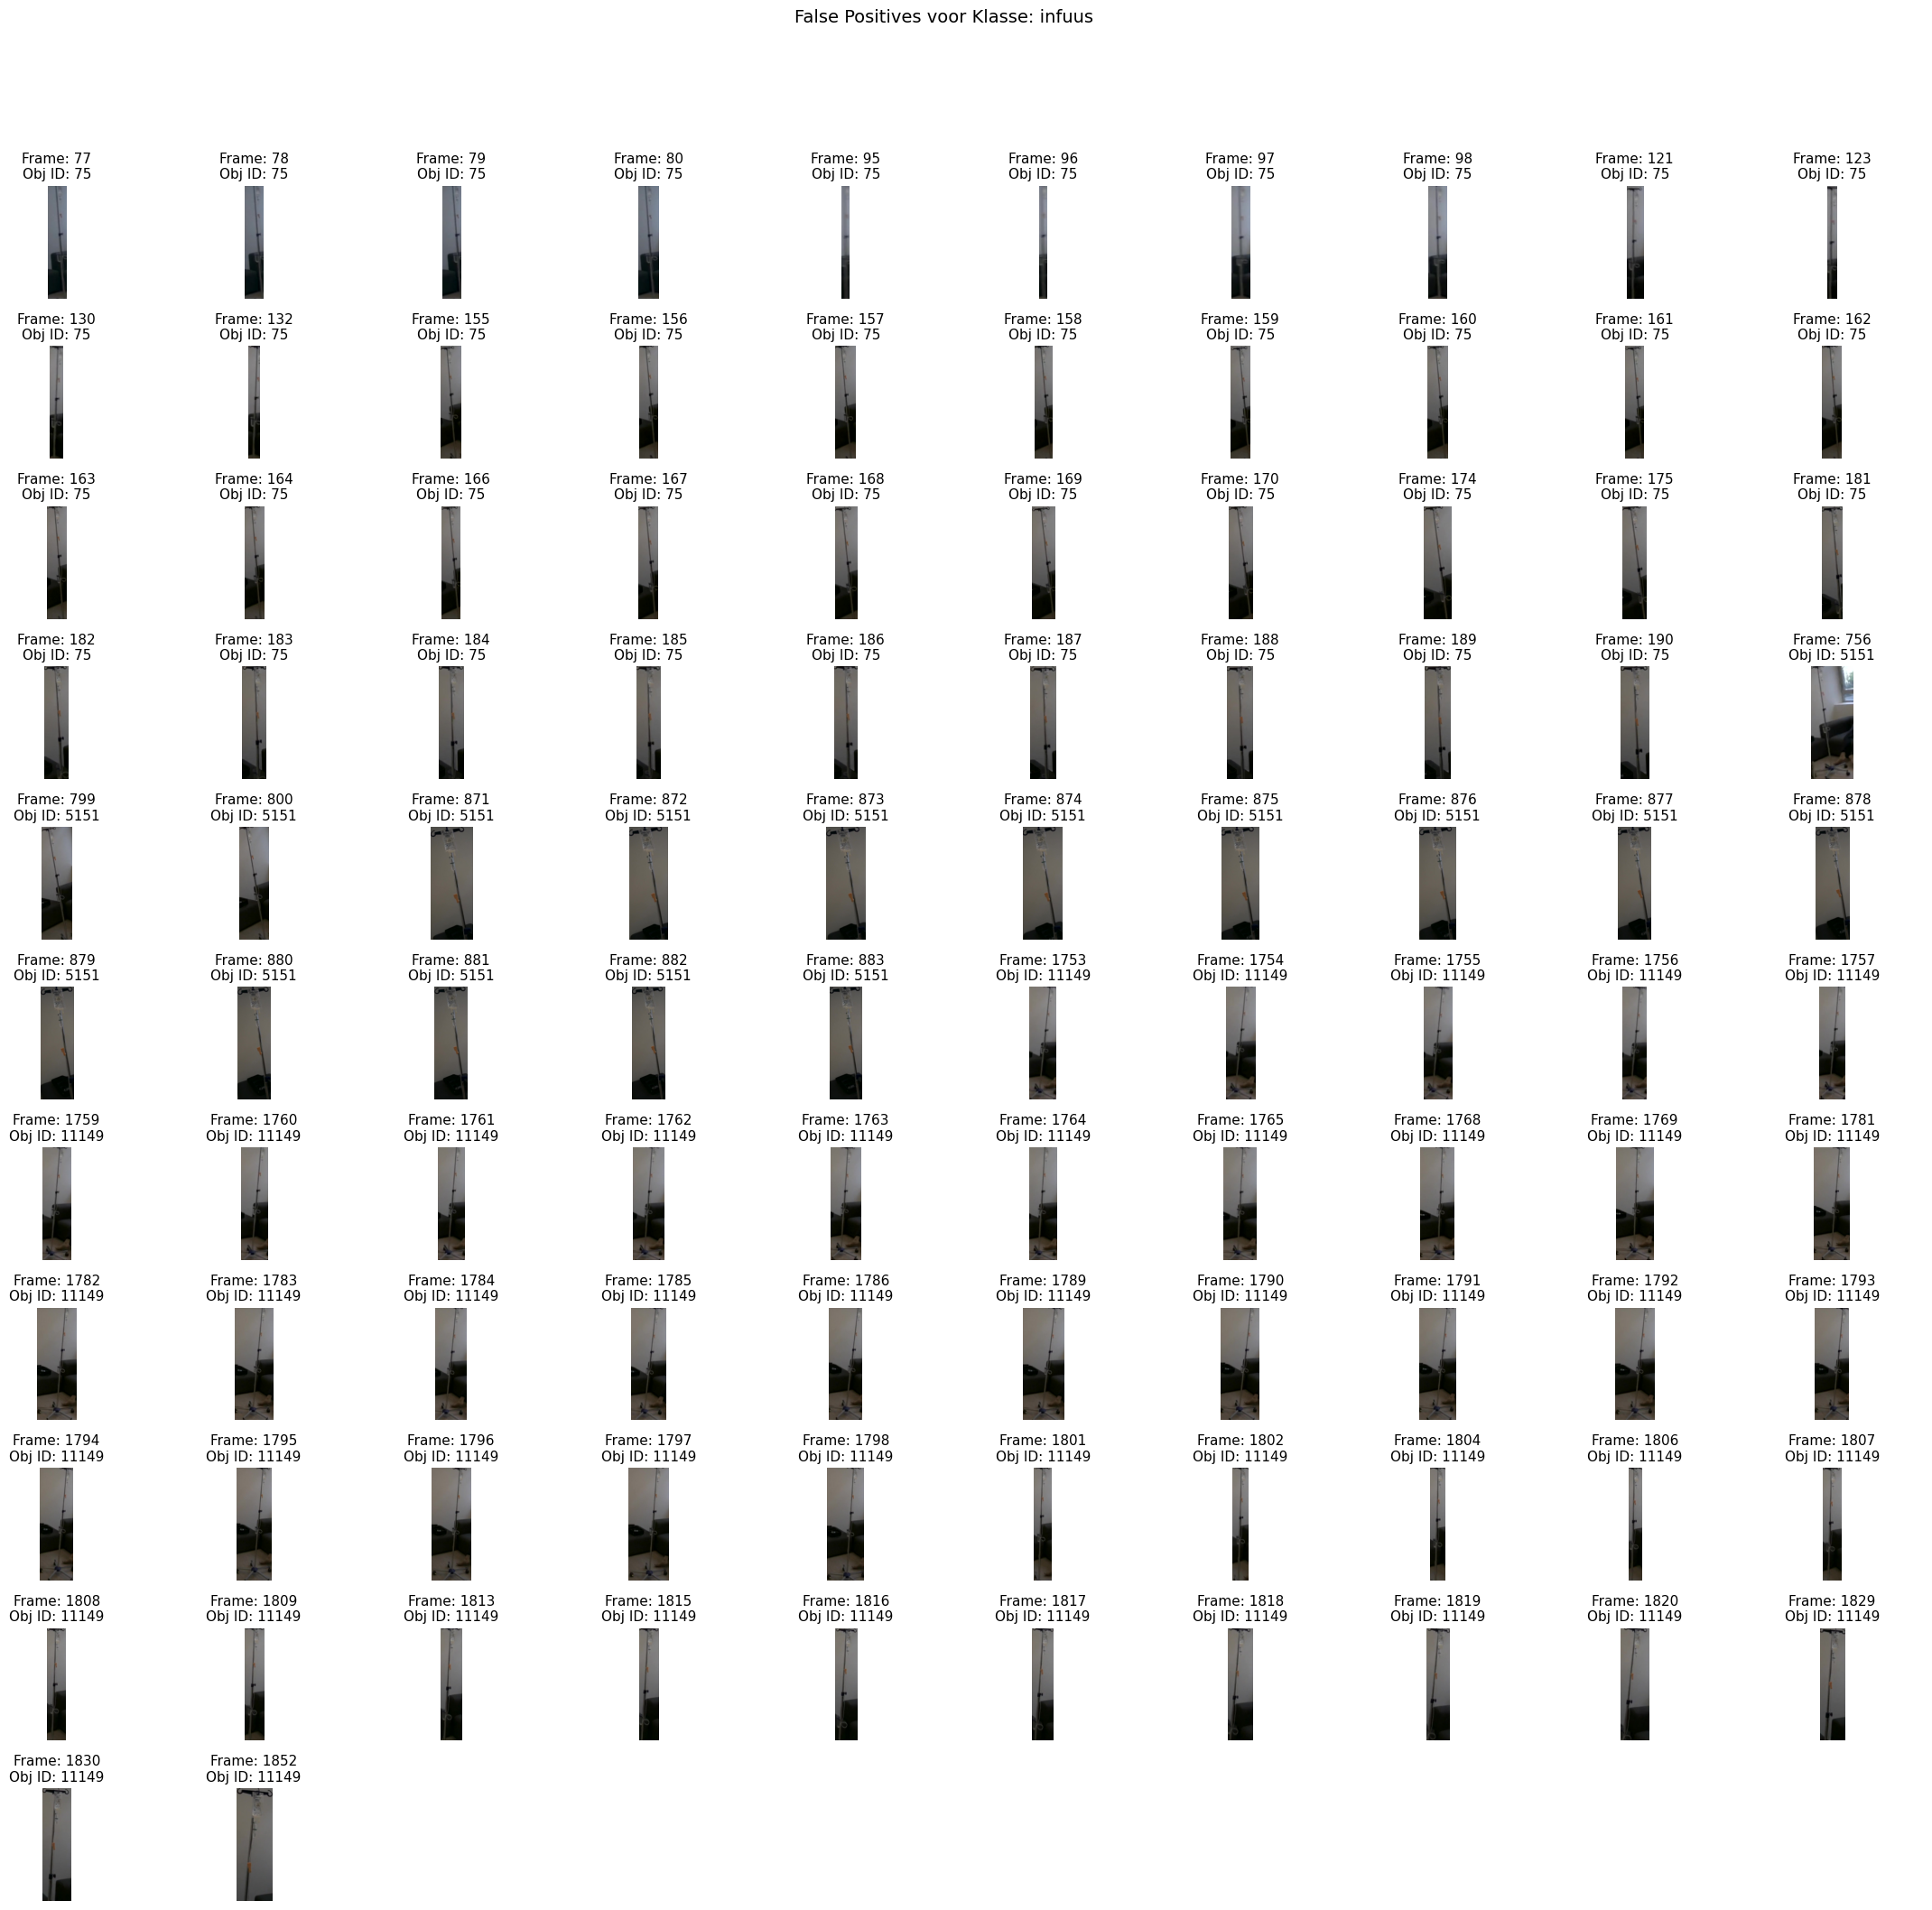

Predicted Class ID: 5.0 (stethoscoop) with 29 false positives


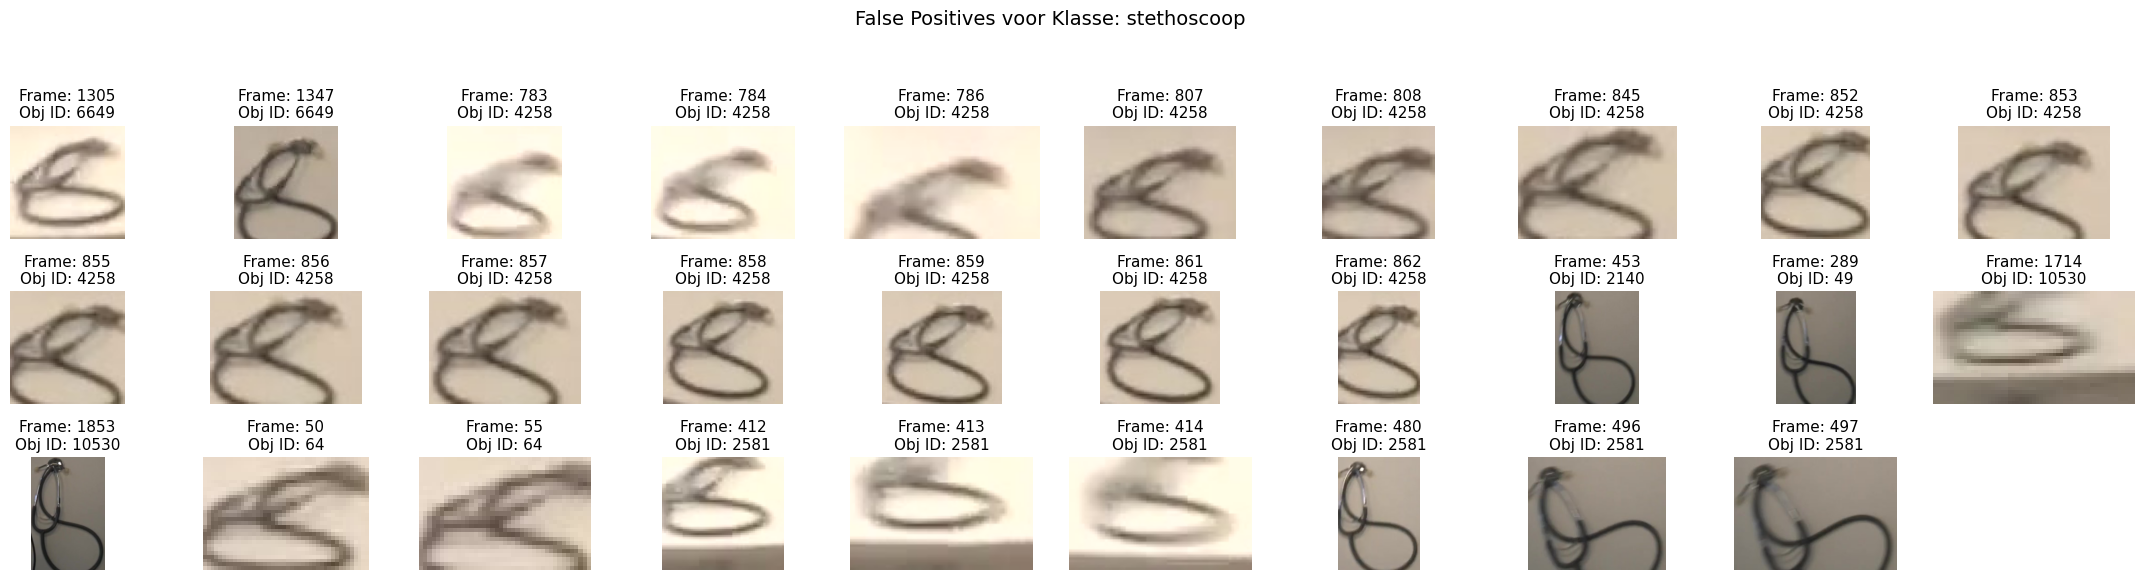

Predicted Class ID: 6.0 (bol wol) with 11 false positives


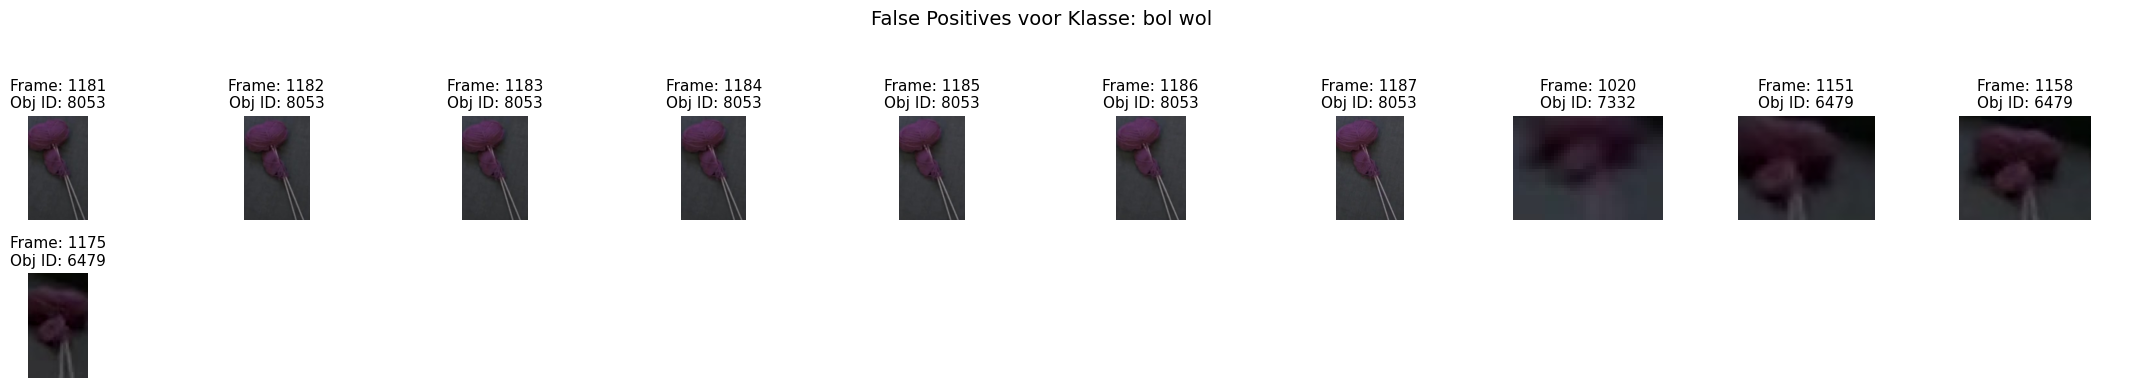

Predicted Class ID: 7.0 (snoep) with 3 false positives


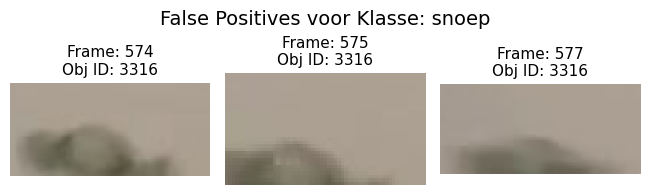

Predicted Class ID: 8.0 (nuchter) with 12 false positives


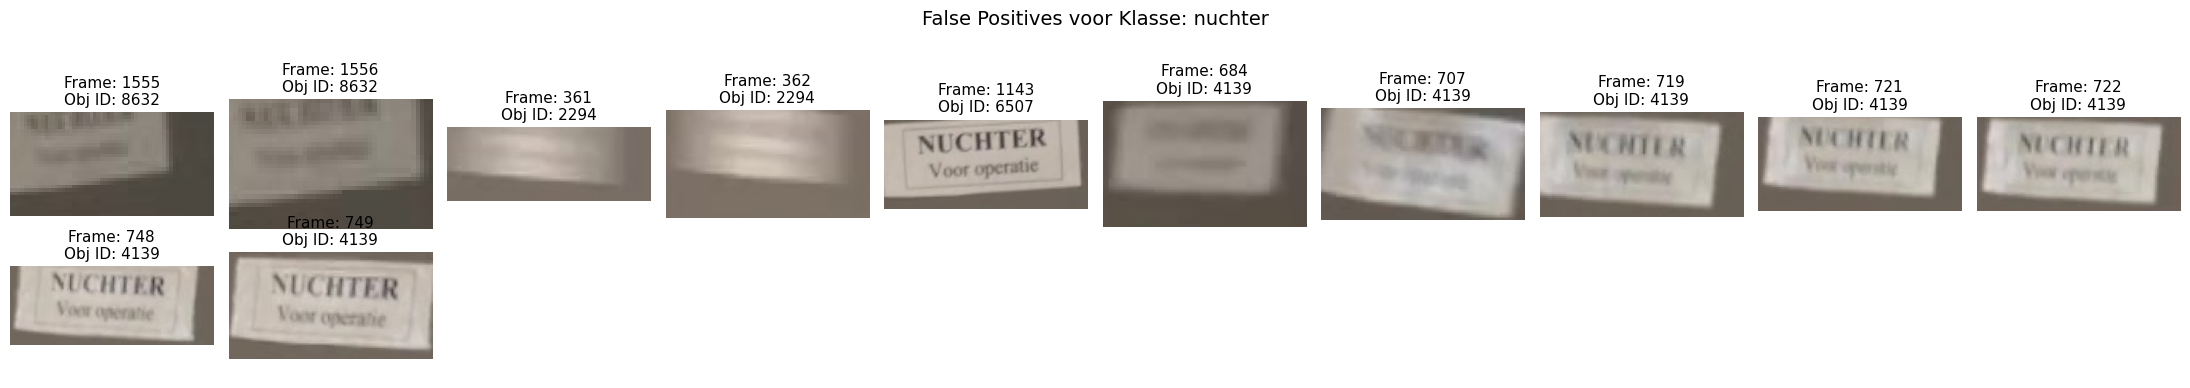

Predicted Class ID: 9.0 (fotokader) with 6 false positives


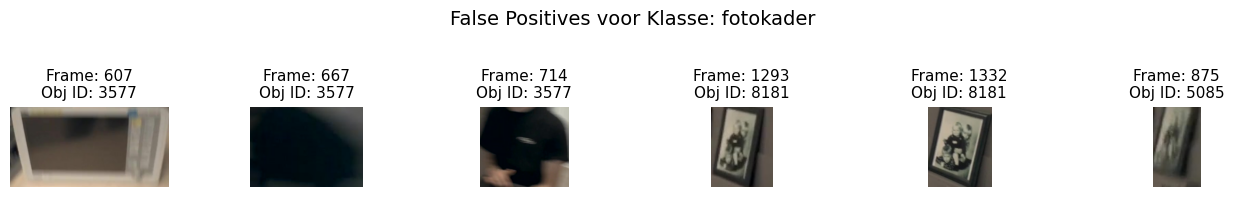

Predicted Class ID: 10.0 (iced tea) with 11 false positives


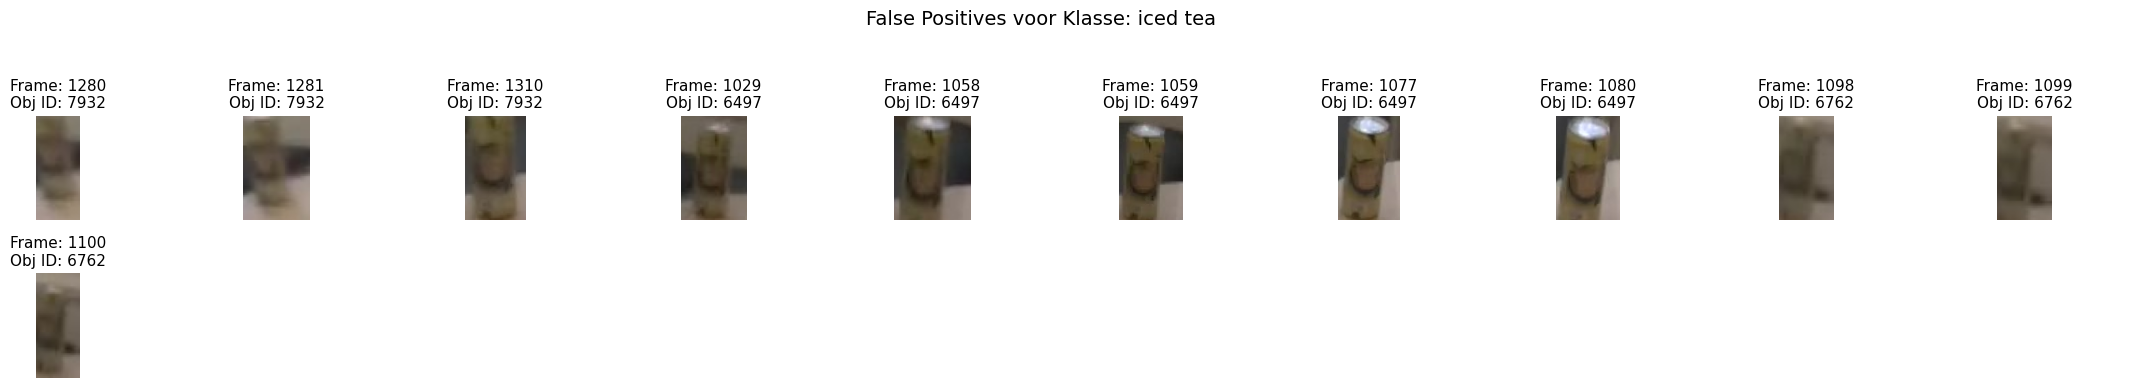

Predicted Class ID: 11.0 (bril) with 30 false positives


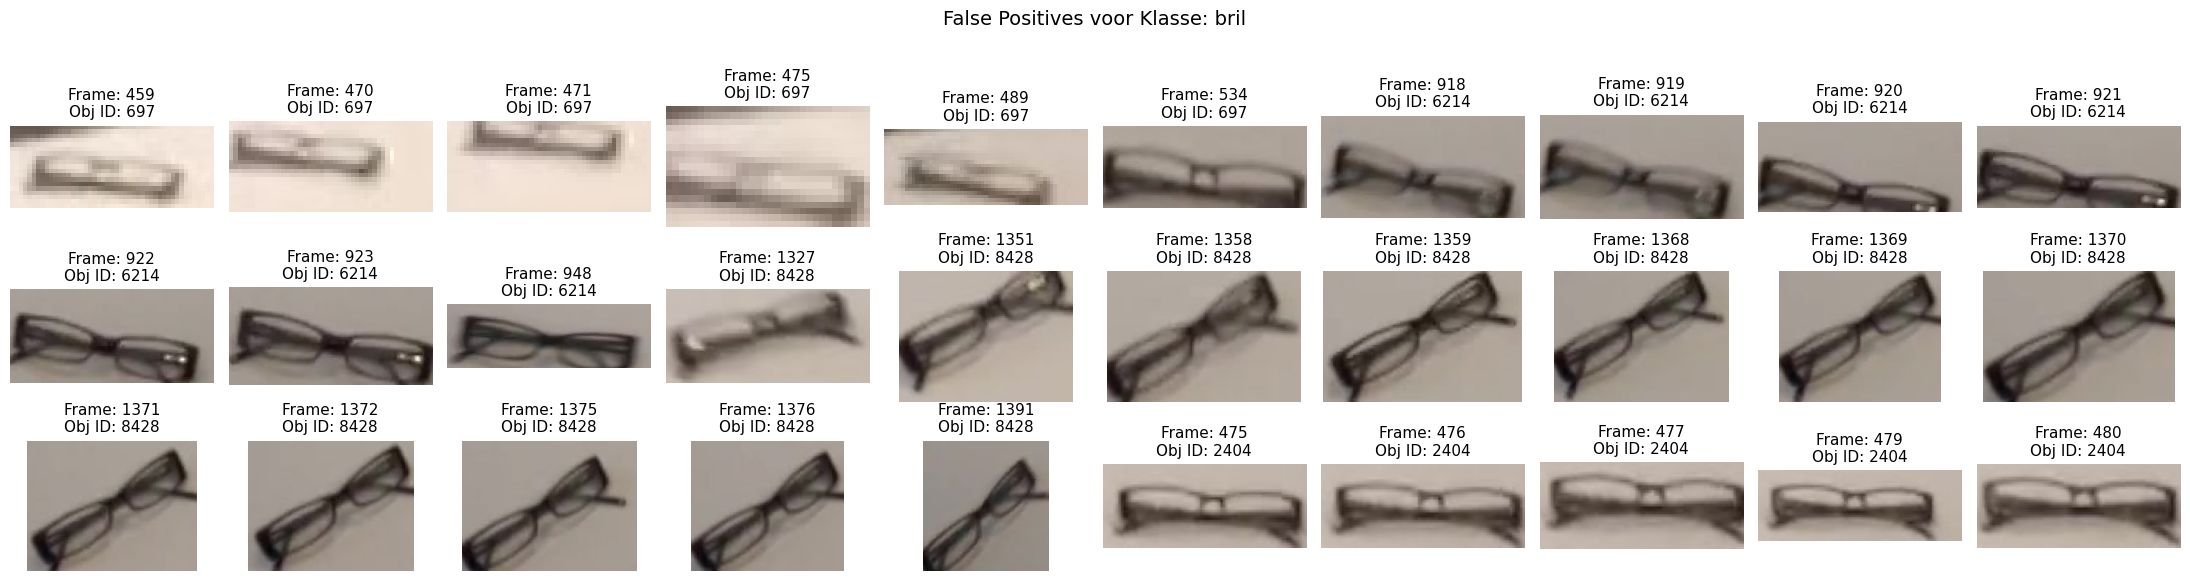

Predicted Class ID: 12.0 (monitor) with 1 false positives


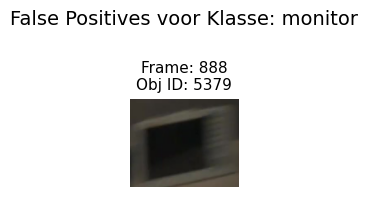

Predicted Class ID: 13.0 (rollator) with 13 false positives


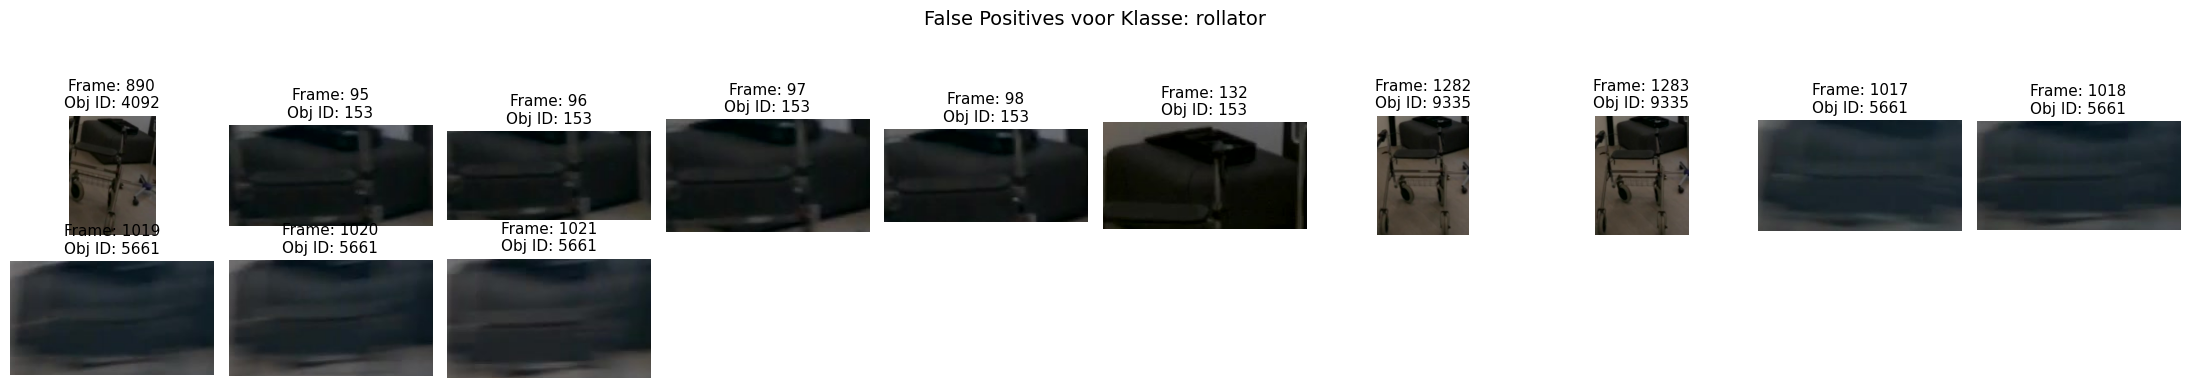

In [17]:
evaluation_df = best_grid_search_result["full_evaluation_df"]
fps_df = evaluation_df[evaluation_df["label"] == "FP"]

print(f"Number of false positives: {len(fps_df)}")

# Group false positives by predicted class instead of recording
for class_id, group in fps_df.groupby("predicted_class_id"):
    print(f"Predicted Class ID: {class_id} ({CLASS_ID_TO_NAME[class_id]}) with {len(group)} false positives")

    rois = []
    frame_indexes = []
    recording_ids = []
    object_ids = []

    for idx, row in group.iterrows():
        recording_id = row["recording_id"]
        frame_idx = row["frame_idx"]
        # Zorg ervoor dat x1, y1, x2, y2 niet NaN zijn voordat je ze naar int converteert
        if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
            print(f"Skipping FP with NaN coordinates: Recording {recording_id}, Frame {frame_idx}, Object ID {row['object_id']}")
            continue
        x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])

        frame_path = RECORDING_FRAMES_PATH / recording_id / f"{int(frame_idx):05d}.jpg"

        image = cv2.imread(str(frame_path))
        if image is None: # Controleer of de afbeelding correct is geladen
            print(f"Warning: Could not read image {frame_path}")
            continue
        
        # Controleer of de ROI coördinaten geldig zijn
        if y1 >= y2 or x1 >= x2 or y1 < 0 or y2 > image.shape[0] or x1 < 0 or x2 > image.shape[1]:
            print(f"Skipping FP with invalid ROI coordinates: Rec {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}] for image shape {image.shape}")
            continue

        roi = image[y1:y2, x1:x2]
        if roi.size == 0: # Controleer of de ROI niet leeg is
            print(f"Skipping FP with empty ROI: Rec {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}]")
            continue

        rois.append(roi)
        frame_indexes.append(frame_idx)
        recording_ids.append(recording_id)
        object_ids.append(row["object_id"])

    if not rois: # Als er geen geldige ROIs zijn voor deze klasse, ga naar de volgende
        print(f"No valid ROIs to display for class {CLASS_ID_TO_NAME[class_id]}")
        continue

    # Sort ROIs by frame index (optioneel, als je ze gesorteerd wilt weergeven)
    # Als je wilt sorteren, moet je alle lijsten (rois, frame_indexes, object_ids) tegelijk sorteren:
    # sorted_data = sorted(zip(rois, frame_indexes, object_ids), key=lambda x: x[1])
    # rois, frame_indexes, object_ids = zip(*sorted_data) if sorted_data else ([], [], [])


    n = len(rois)
    max_cols = 10
    n_cols = min(max_cols, n)
    n_rows = (n + n_cols - 1) // n_cols

    if n == 0: # Voorkom fouten als er geen ROIs zijn na filtering
        plt.figure() # Maak een lege figuur om show() niet te laten falen
        plt.suptitle(f"No False Positives to Display for Class: {CLASS_ID_TO_NAME[class_id]}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        continue

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2 * n_cols, 2 * n_rows), squeeze=False)
    # squeeze=False zorgt ervoor dat 'axes' altijd een 2D array is, zelfs als n_rows of n_cols 1 is.

    # Nu kun je altijd flattenen, omdat het een 2D array is
    axes = axes.flatten()


    for i, roi_img in enumerate(rois): # Hernoemd naar roi_img om conflict met module naam te voorkomen
        axes[i].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
        axes[i].set_title(
            f"Frame: {int(frame_indexes[i])}\nObj ID: {int(object_ids[i])}", # Kortere titel
            fontsize=11, # Kleinere fontsize voor titel
        )

    # Zet resterende, ongebruikte subplots uit
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"False Positives voor Klasse: {CLASS_ID_TO_NAME[class_id]}", fontsize=14) # Iets kleinere suptitle
    plt.tight_layout(rect=[0, 0.02, 1, 0.93]) # Pas rect aan voor meer ruimte voor suptitle en x-labels
    plt.show()

/tmp/ipykernel_165077/929882783.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')


Aantal False Positives voor 'naaldcontainer': 13


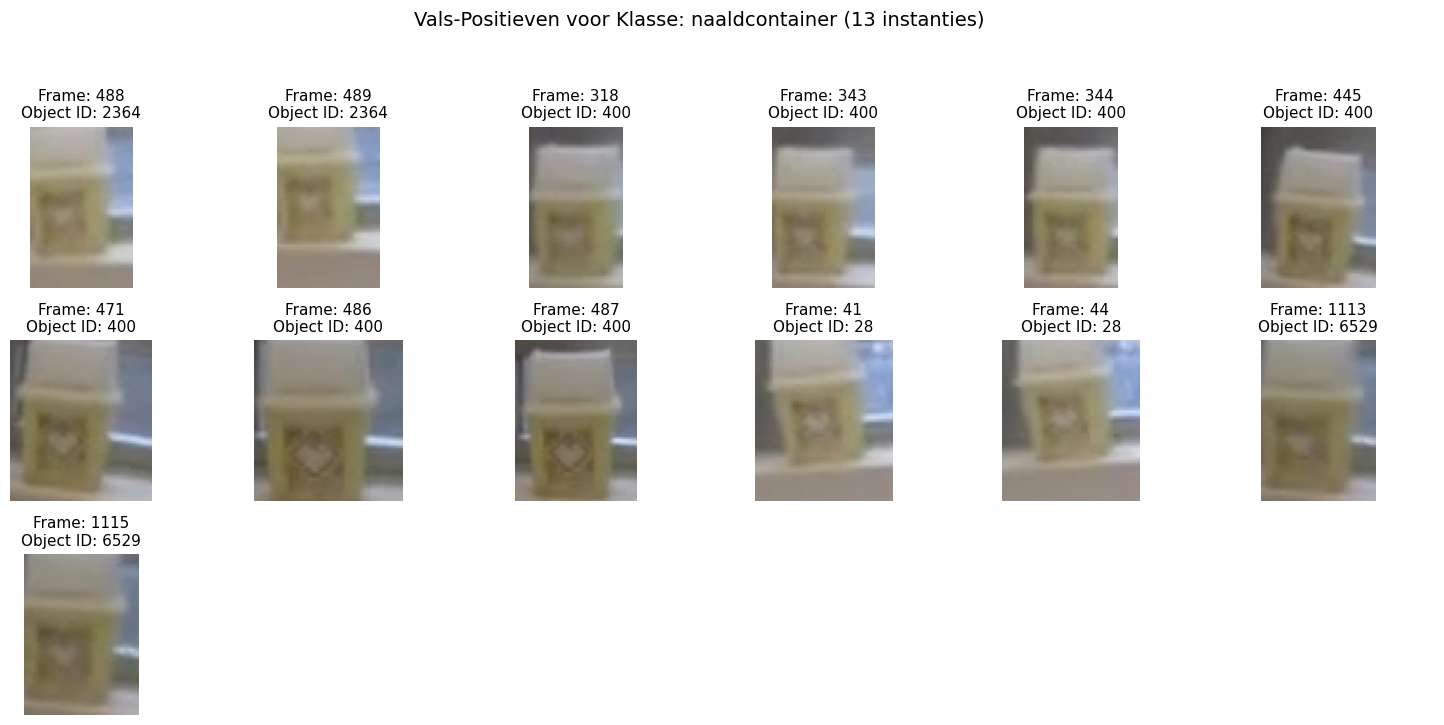

In [42]:
TARGET_CLASS_NAME = "naaldcontainer"
N_COLS = 6 # Aantal kolommen per rij

evaluation_df = best_grid_search_result["full_evaluation_df"]

# Filter op False Positives
fps_df_all = evaluation_df[evaluation_df["label"] == "FP"]

if fps_df_all.empty:
    print("Geen False Positives gevonden in de evaluatiedata.")
else:
    # Filter op de specifieke klasse "naaldcontainer"
    try:
        target_class_id = NAME_TO_CLASS_ID[TARGET_CLASS_NAME]
    except KeyError:
        print(f"Fout: Klasse '{TARGET_CLASS_NAME}' niet gevonden in NAME_TO_CLASS_ID mapping.")
        # Voeg hier eventueel 'exit()' of 'return' toe als dit in een functie staat
        target_class_id = -999 # Een onwaarschijnlijke ID om een lege dataframe te forceren

    # Zorg ervoor dat 'predicted_class_id' numeriek is voor de vergelijking
    fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')
    
    fps_df_target_class = fps_df_all[fps_df_all["predicted_class_id"] == target_class_id]

    if fps_df_target_class.empty:
        print(f"Geen False Positives gevonden voor de klasse: {TARGET_CLASS_NAME}")
    else:
        print(f"Aantal False Positives voor '{TARGET_CLASS_NAME}': {len(fps_df_target_class)}")

        rois_target = []
        frame_indexes_target = []
        object_ids_target = []

        for idx, row in fps_df_target_class.iterrows():
            recording_id = row["recording_id"]
            frame_idx = row["frame_idx"]
            
            # Controleer op NaN waarden voor coördinaten
            if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
                print(f"  Skipping FP (NaN coördinaten): Opn. {recording_id}, Frame {frame_idx}, Obj ID {row['object_id']}")
                continue
            
            x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
            frame_path = RECORDING_FRAMES_PATH / str(recording_id) / f"{int(frame_idx):05d}.jpg"

            image = cv2.imread(str(frame_path))
            if image is None:
                print(f"  Waarschuwing: Kon afbeelding niet lezen {frame_path}")
                continue
            
            # Controleer geldigheid ROI coördinaten en grootte
            if not (0 <= y1 < y2 <= image.shape[0] and 0 <= x1 < x2 <= image.shape[1]):
                print(f"  Skipping FP (ongeldige ROI): Opn. {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}] voor afb. shape {image.shape}")
                continue

            roi = image[y1:y2, x1:x2]
            if roi.size == 0:
                 print(f"  Skipping FP (lege ROI): Opn. {recording_id}, Frame {frame_idx}, Box [{x1},{y1},{x2},{y2}]")
                 continue

            rois_target.append(roi)
            frame_indexes_target.append(frame_idx)
            object_ids_target.append(row["object_id"])
        
        if not rois_target:
            print(f"Geen geldige ROIs om weer te geven voor False Positives van klasse '{TARGET_CLASS_NAME}'.")
        else:
            n_rois = len(rois_target)
            n_rows = (n_rois + N_COLS - 1) // N_COLS # Bereken aantal rijen

            fig, axes = plt.subplots(n_rows, N_COLS, figsize=(2.5 * N_COLS, 2.5 * n_rows), squeeze=False)
            axes_flat = axes.flatten() # Flatten altijd, want squeeze=False

            for i, roi_img in enumerate(rois_target):
                axes_flat[i].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
                axes_flat[i].axis("off")
                axes_flat[i].set_title(
                    f"Frame: {int(frame_indexes_target[i])}\nObject ID: {int(object_ids_target[i])}",
                    fontsize=11
                )
            
            # Zet resterende, ongebruikte subplots uit
            for j in range(n_rois, len(axes_flat)):
                axes_flat[j].axis("off")

            fig.suptitle(f"Vals-Positieven voor Klasse: {TARGET_CLASS_NAME} ({n_rois} instanties)", fontsize=14)
            plt.tight_layout(rect=[0, 0.02, 1, 0.94]) # rect=[left, bottom, right, top]
            plt.show()

/tmp/ipykernel_165077/2912413661.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')


Totaal aantal False Positives voor 'infuus': 102
Willekeurig 6 van de 102 FP's voor 'infuus' geselecteerd om te tonen.


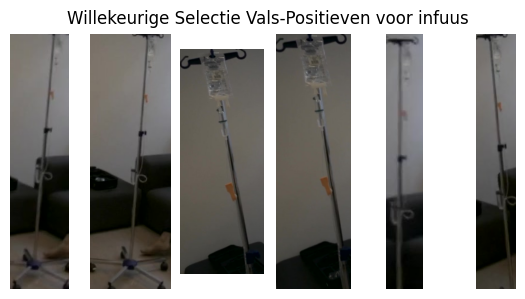

In [41]:
import random

TARGET_CLASS_NAME = "infuus"
N_EXAMPLES_TO_SHOW = 6
N_COLS_FIXED = 6 # We willen altijd 6 kolommen (of minder als er minder voorbeelden zijn)

evaluation_df = best_grid_search_result["full_evaluation_df"]
fps_df_all = evaluation_df[evaluation_df["label"] == "FP"]

if fps_df_all.empty:
    print("Geen False Positives gevonden in de evaluatiedata.")
else:
    try:
        target_class_id = NAME_TO_CLASS_ID[TARGET_CLASS_NAME]
    except KeyError:
        print(f"Fout: Klasse '{TARGET_CLASS_NAME}' niet gevonden in NAME_TO_CLASS_ID mapping.")
        target_class_id = -999

    fps_df_all['predicted_class_id'] = pd.to_numeric(fps_df_all['predicted_class_id'], errors='coerce')
    fps_df_target_class = fps_df_all[fps_df_all["predicted_class_id"] == target_class_id]

    if fps_df_target_class.empty:
        print(f"Geen False Positives gevonden voor de klasse: {TARGET_CLASS_NAME}")
    else:
        print(f"Totaal aantal False Positives voor '{TARGET_CLASS_NAME}': {len(fps_df_target_class)}")

        all_valid_fps_data = [] # Lijst om tuples van (roi, frame_idx, object_id) op te slaan
        for idx, row in fps_df_target_class.iterrows():
            recording_id = row["recording_id"]
            frame_idx = row["frame_idx"]
            
            if pd.isna(row["x1"]) or pd.isna(row["y1"]) or pd.isna(row["x2"]) or pd.isna(row["y2"]):
                continue
            
            x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
            frame_path = RECORDING_FRAMES_PATH / str(recording_id) / f"{int(frame_idx):05d}.jpg"
            image = cv2.imread(str(frame_path))

            if image is None:
                continue
            
            if not (0 <= y1 < y2 <= image.shape[0] and 0 <= x1 < x2 <= image.shape[1]):
                continue

            roi = image[y1:y2, x1:x2]
            if roi.size == 0:
                 continue
            
            all_valid_fps_data.append((roi, frame_idx, row["object_id"]))
        
        if not all_valid_fps_data:
            print(f"Geen geldige ROIs om weer te geven voor False Positives van klasse '{TARGET_CLASS_NAME}'.")
        else:
            # Selecteer willekeurig N voorbeelden
            if len(all_valid_fps_data) > N_EXAMPLES_TO_SHOW:
                selected_fps_data = random.sample(all_valid_fps_data, N_EXAMPLES_TO_SHOW)
                print(f"Willekeurig {N_EXAMPLES_TO_SHOW} van de {len(all_valid_fps_data)} FP's voor '{TARGET_CLASS_NAME}' geselecteerd om te tonen.")
            else:
                selected_fps_data = all_valid_fps_data
                print(f"Alle {len(all_valid_fps_data)} FP's voor '{TARGET_CLASS_NAME}' worden getoond (minder dan of gelijk aan {N_EXAMPLES_TO_SHOW}).")

            n_rois_to_plot = len(selected_fps_data)
            
            # Bepaal aantal kolommen en rijen voor de plot
            # Als er minder dan N_COLS_FIXED voorbeelden zijn, gebruik dan het werkelijke aantal als kolommen
            current_n_cols = min(n_rois_to_plot, N_COLS_FIXED) 
            if current_n_cols == 0: # Voorkom ZeroDivisionError als n_rois_to_plot 0 is
                 n_rows = 0
            else:
                n_rows = (n_rois_to_plot + current_n_cols - 1) // current_n_cols


            if n_rois_to_plot > 0 :
                fig_width = current_n_cols # Kleinere breedte per subplot voor strakkere layout
                fig_height = 3 * n_rows # Hoogte is afhankelijk van ROI-hoogte
                
                fig, axes = plt.subplots(n_rows, current_n_cols, figsize=(fig_width, fig_height), squeeze=False)
                axes_flat = axes.flatten()

                for i, (roi_img, frame_idx_val, object_id_val) in enumerate(selected_fps_data):
                    axes_flat[i].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
                    axes_flat[i].axis("off")

                for j in range(n_rois_to_plot, len(axes_flat)):
                    axes_flat[j].axis("off")

                fig.suptitle(f"Willekeurige Selectie Vals-Positieven voor {TARGET_CLASS_NAME}", fontsize=12)
                plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.05, right=0.95, top=0.90, bottom=0.05) # Strakkere layout
                plt.show()
            else:
                print(f"Geen FP's geselecteerd om te plotten voor {TARGET_CLASS_NAME}")

Model: 2000_samples
Min Pred Conf: 0.7
IoU Threshold: 0.2
Min Glance Frame Count: 5

Overall Accuracy: 0.6694
Micro Precision: 0.9438
Micro Recall: 0.6972
Micro F1: 0.8020

Per Class Metrics:
Class Name Precision  Recall     F1         Support   
naaldcontainer 0.9810     0.9413     0.9607     715       
spuit      0.9234     0.4717     0.6245     460       
keukenmes  0.9617     0.6034     0.7415     416       
infuus     0.7571     0.6839     0.7186     465       
stethoscoop 0.9364     0.7666     0.8430     557       
bol wol    0.9716     0.8529     0.9084     442       
snoep      0.9848     0.5417     0.6989     360       
nuchter    0.9643     0.8244     0.8889     393       
fotokader  0.9774     0.6684     0.7939     389       
iced tea   0.9560     0.7221     0.8227     331       
bril       0.8810     0.7192     0.7919     381       
monitor    1.0000     0.7431     0.8526     506       
rollator   0.9888     0.7564     0.8571     349       
ampulevloeistof 1.0000     0.2287

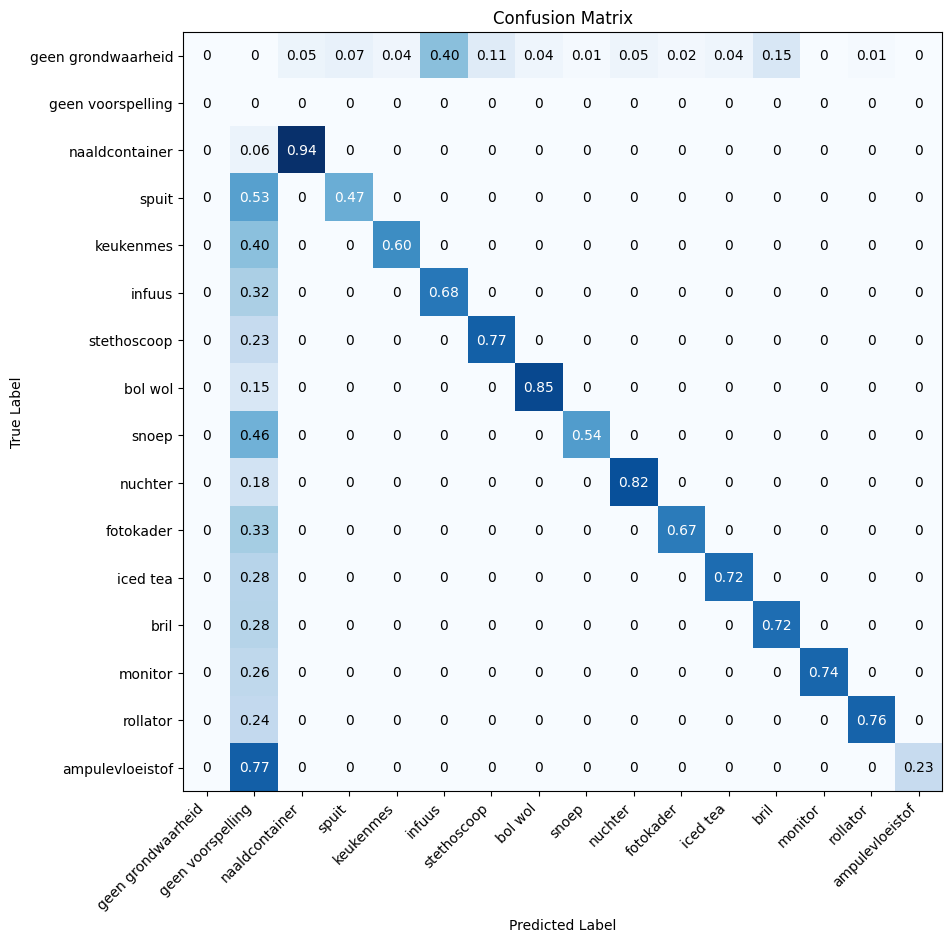

In [ ]:
best_grid_search_result = get_best_grid_search_result(
    grid_sesarch_results=grid_search_results, metric="micro_f1"
)

render_grid_search_result(result=best_grid_search_result)

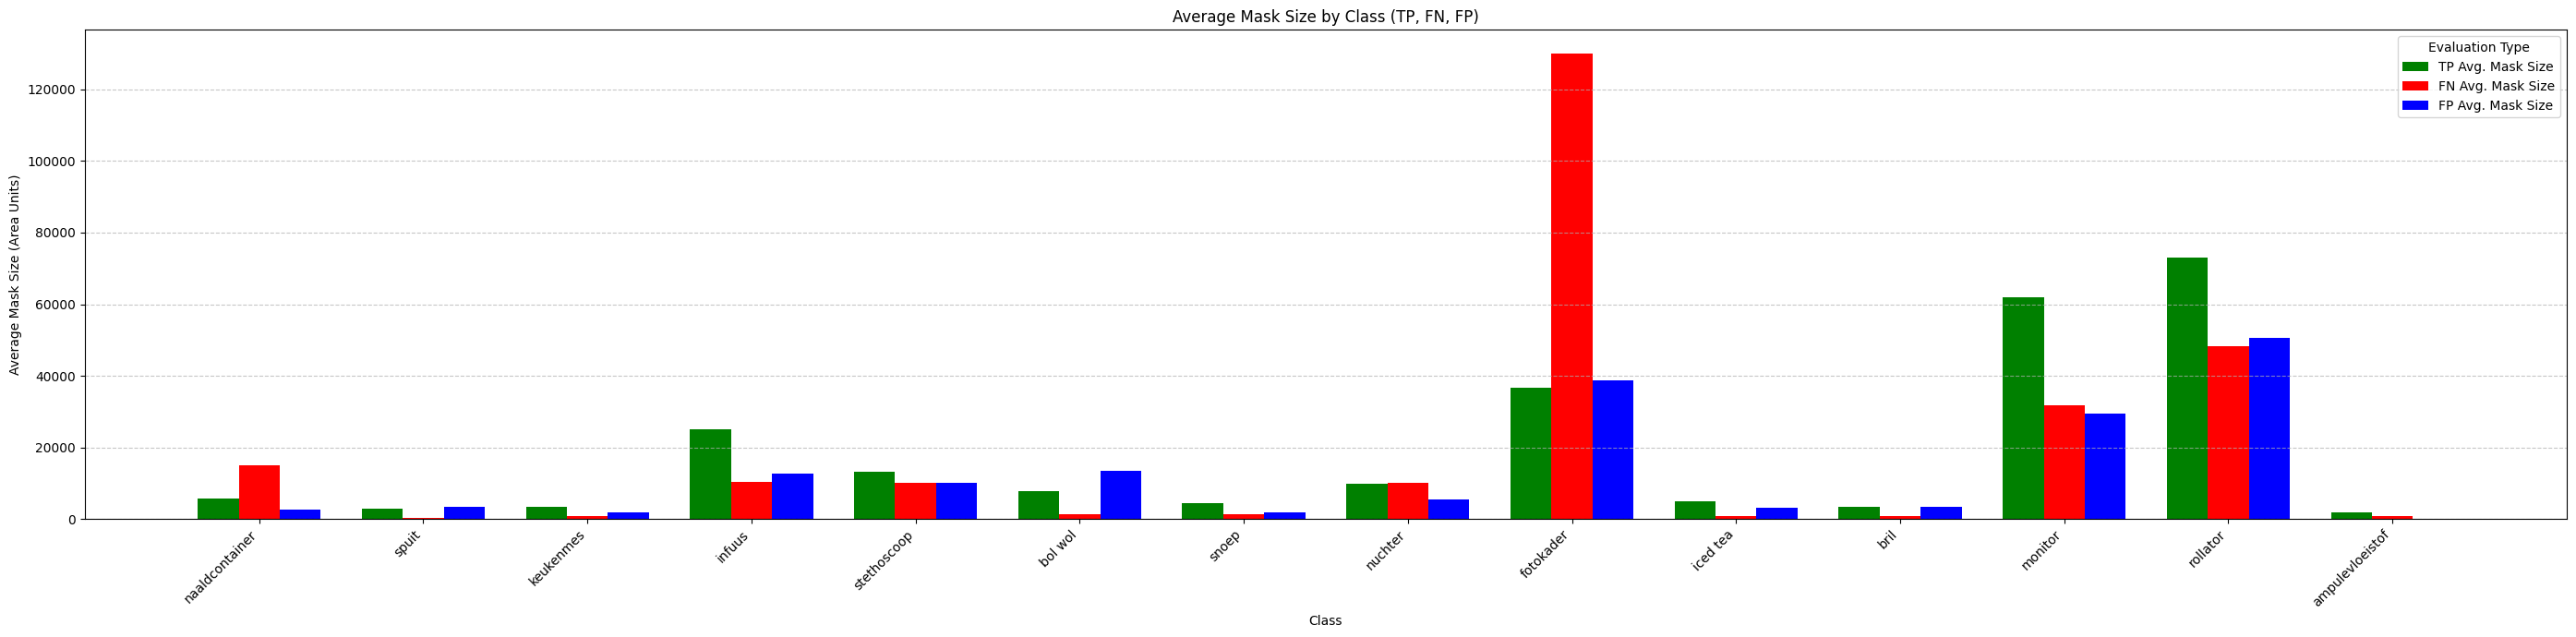

In [ ]:
from experiment.settings import MISSING_GROUND_TRUTH_CLASS_ID, MISSING_PREDICTION_CLASS_ID


def plot_avg_mask_size_by_class(
    eval_df: pd.DataFrame,
):
    plot_df = eval_df.copy()

    # Filter out rows where target_metric is NaN (e.g., FNs from GTs without bbox info, or invalid bboxes)
    target_metric = "mask_area"
    plot_df = plot_df.dropna(subset=[target_metric])
    if plot_df.empty:
        print(f"No valid data with {target_metric} found in eval_df.")
        return

    tps_df = plot_df[plot_df["label"] == "TP"]
    avg_mask_tp = (
        tps_df.groupby("true_class_id")[target_metric].mean().rename("TP Avg. Mask Size")
    )

    fns_df = plot_df[plot_df["label"] == "FN"]
    avg_mask_fn = (
        fns_df.groupby("true_class_id")[target_metric].mean().rename("FN Avg. Mask Size")
    )

    fps_df = plot_df[plot_df["label"] == "FP"]
    avg_mask_fp = (
        fps_df.groupby("predicted_class_id")[target_metric]
        .mean()
        .rename("FP Avg. Mask Size")
    )

    # 3. Merge the series
    plot_data = pd.concat([avg_mask_tp, avg_mask_fn, avg_mask_fp], axis=1)

    # Filter out any special class IDs that might have ended up as an index
    # (e.g. if a true_class_id in FNs was accidentally a special ID)
    special_ids_for_index = {
        UNKNOWN_CLASS_ID,
        MISSING_GROUND_TRUTH_CLASS_ID,
        MISSING_PREDICTION_CLASS_ID,
    }
    valid_class_indices = [
        idx
        for idx in plot_data.index
        if idx not in special_ids_for_index and pd.notna(idx)
    ]
    plot_data = plot_data.loc[valid_class_indices]

    if plot_data.empty:
        print(
            "No data available to plot after filtering classes and calculating averages."
        )
        return

    # Fill NaN with 0 for classes that might not have TPs, FPs, or FNs for mask size.
    plot_data = plot_data.fillna(0)
    plot_data = plot_data.sort_index()  # Sort by class ID

    # 4. Plotting
    n_classes = len(plot_data)
    if n_classes == 0:
        print("No classes with valid data to plot.")
        return

    fig, ax = plt.subplots(
        figsize=(max(10, n_classes * 2), 7)
    )  # Adjust width based on num classes

    bar_width = 0.25
    index = np.arange(n_classes)

    # Define colors for bars
    tp_color = "green"
    fn_color = "red"
    fp_color = "blue"

    ax.bar(
        index - bar_width,
        plot_data["TP Avg. Mask Size"],
        bar_width,
        label="TP Avg. Mask Size",
        color=tp_color,
    )
    ax.bar(
        index,
        plot_data["FN Avg. Mask Size"],
        bar_width,
        label="FN Avg. Mask Size",
        color=fn_color,
    )
    ax.bar(
        index + bar_width,
        plot_data["FP Avg. Mask Size"],
        bar_width,
        label="FP Avg. Mask Size",
        color=fp_color,
    )

    ax.set_xlabel("Class")
    ax.set_ylabel("Average Mask Size (Area Units)")
    ax.set_title("Average Mask Size by Class (TP, FN, FP)")

    tick_labels = plot_data.index
    tick_labels = [CLASS_ID_TO_NAME.get(cid, str(cid)) for cid in plot_data.index]

    ax.set_xticks(index)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")

    ax.legend(title="Evaluation Type")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    fig.tight_layout()
    plt.show()


evaluation_df = best_grid_search_result["full_evaluation_df"]
plot_avg_mask_size_by_class(evaluation_df)

# Analyze False Negatives in best result

# Render Final Predictions

In [ ]:
def draw_video_frames(
    session: Session,
    frames: list[Path],
    frame_to_gaze_position: dict[int, tuple[int, int]],
    predictions_df: pd.DataFrame,
    draw_unknowns: bool = False,
):
    # Iterate over frames and draw the annotations on them if they exist
    for frame in tqdm(frames, desc="Drawing annotations on frames"):
        frame_idx = int(frame.stem)
        frame_img = cv2.imread(str(frame))

        # iterate through the predictions with the same frame index
        frame_predictions = predictions_df[predictions_df["frame_idx"] == frame_idx]
        for _, row in frame_predictions.iterrows():
            class_id = int(row["predicted_class_id"])
            class_name = CLASS_ID_TO_NAME[class_id]
            box = (int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"]))

            try:
                simroom_class = simrooms_service.get_simroom_class(session, class_id)
                color = simroom_class.color
            except:
                if draw_unknowns:
                    color = "#FF0000"
                else:
                    continue

            frame_img = image_utils.draw_labeled_box(frame_img, box, class_name, color)

        # Draw the gaze point on the frame
        if frame_to_gaze_position.get(frame_idx) is not None:
            gx, gy = frame_to_gaze_position[frame_idx]

            cv2.circle(
                frame_img,
                (int(gx), int(gy)),
                radius=VIEWED_RADIUS,
                color=(0, 0, 255),
                thickness=2,
            )

        # Save the modified image back to its original location
        cv2.imwrite(str(frame), frame_img)

In [ ]:
for model in models:
    model_name = model.stem
    model = YOLO(model)

    if FINAL_PREDICTION_VIDEOS_PATH.exists():
        shutil.rmtree(FINAL_PREDICTION_VIDEOS_PATH)
    FINAL_PREDICTION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

    prediction_results = (OBJECT_DETECTION_PREDICTIONS_PATH / model_name).iterdir()
    for prediction_result_path in prediction_results:
        recording_id = prediction_result_path.stem
        predictions_df = pd.read_csv(prediction_result_path)

        video_path = RECORDINGS_PATH / f"{recording_id}.mp4"

        frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
        tmp_frames_path = Path(tmp_frames_dir.name)

        frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(
            recording_id, len(frames)
        )

        with Session(engine) as session:
            draw_video_frames(
                session=session,
                frames=frames,
                frame_to_gaze_position=frame_to_gaze_position,
                predictions_df=predictions_df,
            )

        print(f"Creating video for {recording_id}")
        video_result_path = FINAL_PREDICTION_VIDEOS_PATH / f"{recording_id}.mp4"
        cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
        subprocess.run(cmd, shell=True)

Drawing annotations on frames: 100%|██████████| 1365/1365 [00:10<00:00, 127.80it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheo

Creating video for 32f02db7-adc0-4556-a2da-ed2ba60a58c9


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55d7c25c7940] using SAR=1/1
[libx264 @ 0x55d7c25c7940] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55d7c25c7940] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55d7c25c7940] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1

Creating video for 67b71a70-da64-467a-9fb6-91bc29265fd1


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55d653650380] using SAR=1/1
[libx264 @ 0x55d653650380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55d653650380] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55d653650380] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1

Drawing annotations on frames: 100%|██████████| 1557/1557 [00:11<00:00, 132.72it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheo

Creating video for b8eeecc0-06b1-47f7-acb5-89aab3c1724d


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x56058b8b4b00] using SAR=1/1
[libx264 @ 0x56058b8b4b00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x56058b8b4b00] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x56058b8b4b00] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1